In [ ]:
import polars as pl
import matplotlib.pyplot as plt

import pyref as rf
import pyref.fitting as fit
import numpy as np

import pickle as pk
from copy import deepcopy
from pathlib import Path

# Load the Data Files

shape: (5, 6)
┌──────────────────────┬───────────┬─────┬──────┬──────────┬──────────┐
│ Beamline Energy [eV] ┆ sample    ┆ pol ┆ bt   ┆ Q        ┆ r        │
│ ---                  ┆ ---       ┆ --- ┆ ---  ┆ ---      ┆ ---      │
│ f64                  ┆ str       ┆ str ┆ str  ┆ f64      ┆ f64      │
╞══════════════════════╪═══════════╪═════╪══════╪══════════╪══════════╡
│ 283.7                ┆ monolayer ┆ s   ┆ june ┆ 0.0      ┆ 1.0      │
│ 275.0                ┆ monolayer ┆ s   ┆ june ┆ 0.001012 ┆ 0.932947 │
│ 280.0                ┆ monolayer ┆ s   ┆ june ┆ 0.00103  ┆ 0.860302 │
│ 281.0                ┆ monolayer ┆ s   ┆ june ┆ 0.001034 ┆ 0.71063  │
│ 281.2                ┆ monolayer ┆ s   ┆ june ┆ 0.001035 ┆ 0.81888  │
└──────────────────────┴───────────┴─────┴──────┴──────────┴──────────┘

[250.  275.  280.  281.  281.2 281.4 281.6 281.8 282.  282.3 282.5 282.7
 282.9 283.1 283.3 283.5 283.7 284.2 285.1 287.  289. ]


(<Axes: ylabel='$R$'>, <Axes: xlabel='$q (\\AA^{-1})$'>)

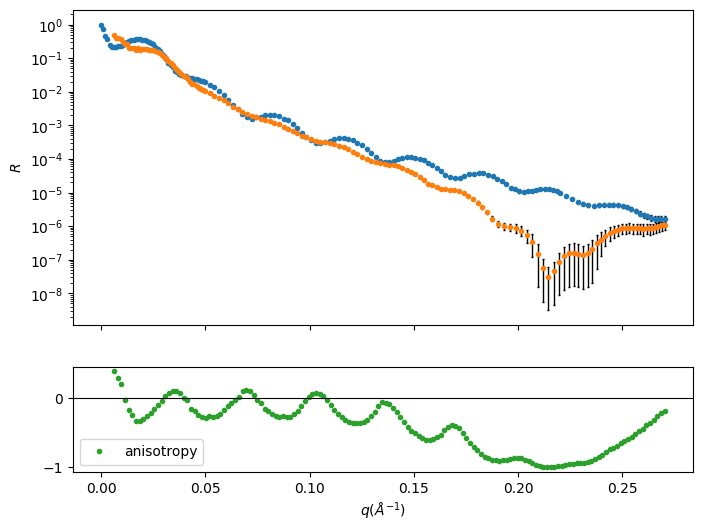

In [11]:
df = pl.read_parquet("june_processed.parquet").sort(pl.col("Q")).sort(pl.col("pol"), descending=True)
df = df.filter(pl.col("sample").str.starts_with("mono"))

display(df.head())
data = {}
for en, g in df.group_by("Beamline Energy [eV]", maintain_order=True):
    Q = g["Q"].to_numpy()
    R = g["r"].to_numpy()
    # Calculate initial dR
    dR = 0.05 * R + 1e-6 * Q
    # Ensure dR doesn't exceed 90% of R to keep R-dR positive
    dR = np.minimum(dR, 0.9 * R)
    ds = fit.XrayReflectDataset(data=(Q, R, dR))
    data[str(en[0])] = ds
energy_ = df["Beamline Energy [eV]"].unique().to_numpy()
print(energy_)
energy_ = np.array([250, 275, 280, 281, 282, 282.3, 282.5, 283.1, 283.5, 283.7, 284.2, 285.1, 287, 289])
# energy_ = np.array([283.7])
data["283.7"].plot()

# Load Optical Constants for Constraints and OOC instantiation

array([283.7])

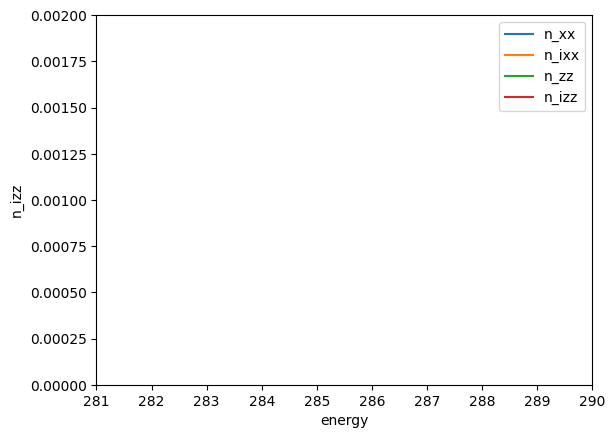

In [12]:
import pandas as pd
import numpy as np

ooc = pd.read_csv(
    'optical_constants.csv',
)
# lets look for extra constraints
c_edge = ooc.query(f"{energy_.min()} < `energy` < {energy_.max()}")
a = c_edge.plot(x = "energy")

def get_multiple_occ(target_energies, df=ooc):
    """
    Interpolate occupation values for multiple target energies
    
    Parameters:
        target_energies: List of energy values to interpolate at
        df: DataFrame containing 'energy' column and other values to interpolate
        
    Returns:
        DataFrame with interpolated values at target energies
    """
    # Create a DataFrame with just the target energies
    target_df = pd.DataFrame({'energy': target_energies})
    
    # Combine with original DataFrame and sort
    combined_df = pd.concat([df, target_df], ignore_index=True)
    combined_df = combined_df.sort_values('energy').reset_index(drop=True)
    
    # Interpolate all columns except 'energy'
    interpolated_df = combined_df.interpolate(method='linear')
    
    # Return only rows matching target energies
    return interpolated_df[interpolated_df['energy'].isin(target_energies)]
c = ooc.columns
selected_ooc = get_multiple_occ(energy_)

selected_ooc["dichroism"] = selected_ooc["n_ixx"] - selected_ooc["n_izz"]
selected_ooc = selected_ooc.query("dichroism >= 0")

selected_ooc.plot(x = "energy", y = c[1], kind = "scatter", ax = a, color = "C0")
selected_ooc.plot(x = "energy", y = c[2], kind = "scatter", ax = a, color = "C1")
selected_ooc.plot(x = "energy", y = c[3], kind = "scatter", ax = a, color = "C2")
selected_ooc.plot(x = "energy", y = c[4], kind = "scatter", ax = a, color = "C3")
plt.ylim(0, 2e-3)
plt.xlim(281, 290)

energy = selected_ooc["energy"].to_numpy()
energy = energy_#[250. , 281. , 282. ,282.3, 282.5, 282.7, 283.7] #284.2,285.1, 287. , 289. ]
energy

In [13]:
energy = energy_#[250. , 281. , 282. ,282.3, 282.5, 282.7, 283.7] #284.2,285.1, 287. , 289. ]
energy

array([283.7])

In [24]:
ZNPC = "C32H16N8Zn"
MA = np.asin(np.sqrt(2 / 3))


def r2(x):
    """Round to 2 significant figures."""
    if x == 0:
        return 0
    else:
        return round(x, -int(np.floor(np.log10(abs(x)))) + 1)


def setp_from_tensor(slab, tensor):
    """Set parameters from tensor."""
    rbounds = (
        r2(tensor.real.min() - 1e-3),
        r2(tensor.real.max() + 1e-3),
    )
    ibounds = (
        1e-6,
        r2(tensor.imag.max() + 1e-3),
    )
    slab.sld.xx.setp(vary=True, bounds=rbounds)
    slab.sld.zz.setp(vary=True, bounds=rbounds)
    slab.sld.ixx.setp(vary=True, bounds=ibounds)
    slab.sld.izz.setp(vary=True, bounds=ibounds)
    return slab


def vacuum(energy):
    """Vacuum."""
    slab = fit.MaterialSLD("", 0, name=f"Vacuum_{energy}")(0, 0)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def substrate(energy, density=2.33):
    """Substrate."""
    slab = fit.MaterialSLD(
        "Si", density=density, energy=energy, name=f"Substrate_{energy}"
    )(10, 1.5)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def sio2(energy, density=2.28):
    """SiO2."""
    slab = fit.MaterialSLD(
        "SiO2", density=density, energy=energy, name=f"Oxide_{energy}"
    )(10, 1.5)
    slab.thick.setp(vary=True, bounds=(1, 10))
    slab.rough.setp(vary=False, bounds=(1, 10))
    slab.sld.density.setp(vary=False)
    return slab


def contamination(energy, density=1.0):
    """Contamination."""
    name = f"Contamination_{energy}"
    if energy < 270:
        slab = fit.MaterialSLD("CHN", density=density, energy=energy, name=name)(
            10, 1.5
        )
        slab.sld.density.setp(vary=True, bounds=(1, 3))
    else:
        iso = fit.MaterialSLD("CHN", density=density, energy=energy).tensor
        slab = fit.SLD(iso, name=name)(10, 1.5)
        slab = setp_from_tensor(slab, iso)

    slab.thick.setp(vary=True, bounds=(1, 10))
    slab.rough.setp(vary=True, bounds=(1, 10))
    return slab


def surface(energy, density=1.0):
    """Surface."""
    name = f"Surface_{energy}"
    if energy < 270:
        slab = fit.MaterialSLD(ZNPC, density=density, energy=energy, name=name)(5, 1.5)
        slab.sld.density.setp(vary=True, bounds=(1, 3))
    else:
        iso = fit.UniTensorSLD(ooc, density=density, rotation=MA, energy=energy).tensor
        slab = fit.SLD(iso, name=name)(5, 1.5)
        slab = setp_from_tensor(slab, iso)

    slab.thick.setp(vary=True, bounds=(1, 10))
    slab.rough.setp(vary=True, bounds=(1, 10))
    return slab


def znpc(energy, density=1.0):
    """ZnPc."""
    name = f"ZnPc_{energy}"
    if energy < 270:
        slab = fit.MaterialSLD(ZNPC, density=density, energy=energy, name=name)(
            200, 1.5
        )
        slab.sld.density.setp(vary=True, bounds=(1, 3))
    if energy > 270 and energy < 284:
        slab = fit.UniTensorSLD(
            ooc, density=density, rotation=MA, energy=energy, name=name
        )(190, 10)
        slab.sld.density.setp(vary=True, bounds=(1, 3))
        slab.sld.rotation.setp(vary=True, bounds=(MA, np.pi/2))
        slab.sld.energy_offset.setp(vary=True, bounds=(-0.3, 0.3))
    if energy > 284:
        slab = fit.SLD(ooc, energy=energy, name=name)(200, 10)
        slab = setp_from_tensor(slab, slab.tensor())

    slab.thick.setp(vary=True, bounds=(180, 210))
    slab.rough.setp(vary=True, bounds=(1, 10))
    return slab


def construct_slab(energy):
    """Construct the slab."""
    slab = (
        vacuum(energy)
        | surface(energy)
        | znpc(energy)
        | contamination(energy)
        | sio2(energy)
        | substrate(energy)
    )
    slab.name = f"Monolayer_{energy}"
    return slab


stacks = {str(en): construct_slab(en) for en in energy}

# Fit Delta Crossing to consistent slab model

In [16]:
PROBE = stacks["283.7"]
NONRES = stacks["250.0"]

PROBE[2].sld.density.setp(vary = None, constraint = NONRES[2].sld.density)

def struct_constraint(slab, constraint):
    slab.thick.setp(vary=None, constraint=constraint.thick)
    slab.rough.setp(vary=None, constraint=constraint.rough)
    return slab

def sld_constraint(slab, constraint):
    # unconstrained slds for the 
    if (
        isinstance(slab.sld, fit.structure.UniTensorSLD)
        and 
        isinstance(constraint.sld, fit.structure.UniTensorSLD)
        ):
        slab.sld.density.setp(vary = None, constraint = constraint.sld.density)
        # slab.sld.rotation.setp(vary = None, constraint = constraint.sld.rotation)
        slab.sld.energy_offset.setp(vary = None, constraint = constraint.sld.energy_offset)
    return slab

def cross_energy_constrain(stack, probe = PROBE):
    # 0: vac, 1: surf, 2: bulk. 3: cont, 4: oxide
    for i, slab in enumerate(stack):
        # constrain the structures to the probe
        slab = struct_constraint(slab, probe[i])
        # constrain the sld for consistency
        slab = sld_constraint(slab, probe[i])
    return stack
    
# stacks = {k: cross_energy_constrain(s) if k != "283.7" else s for k, s in stacks.items()} 

In [15]:
print(stacks["283.7"].parameters)

________________________________________________________________________________
Parameters: 'Structure - Monolayer_283.7'
________________________________________________________________________________
Parameters: 'Vacuum_283.7' 
________________________________________________________________________________
Parameters: 'Vacuum_283.7_slab'
<Parameter:'Vacuum_283.7_thick', value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:'Vacuum_283.7_rough', value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:'Vacuum_283.7_rho', value=0  (fixed) , bounds=[0.0, 0.0]>
________________________________________________________________________________
Parameters: 'Surface_283.7'
________________________________________________________________________________
Parameters: 'Surface_283.7_slab'
<Parameter:'Surface_283.7_thick', value=5          , bounds=[1.0, 10.0]>
<Parameter:'Surface_283.7_rough', value=1.5          , bounds=[1.0, 10.0]>
<Parameter:'Surface_283.7_diso', value=-0.00121163  (fixed) , bounds=[-in

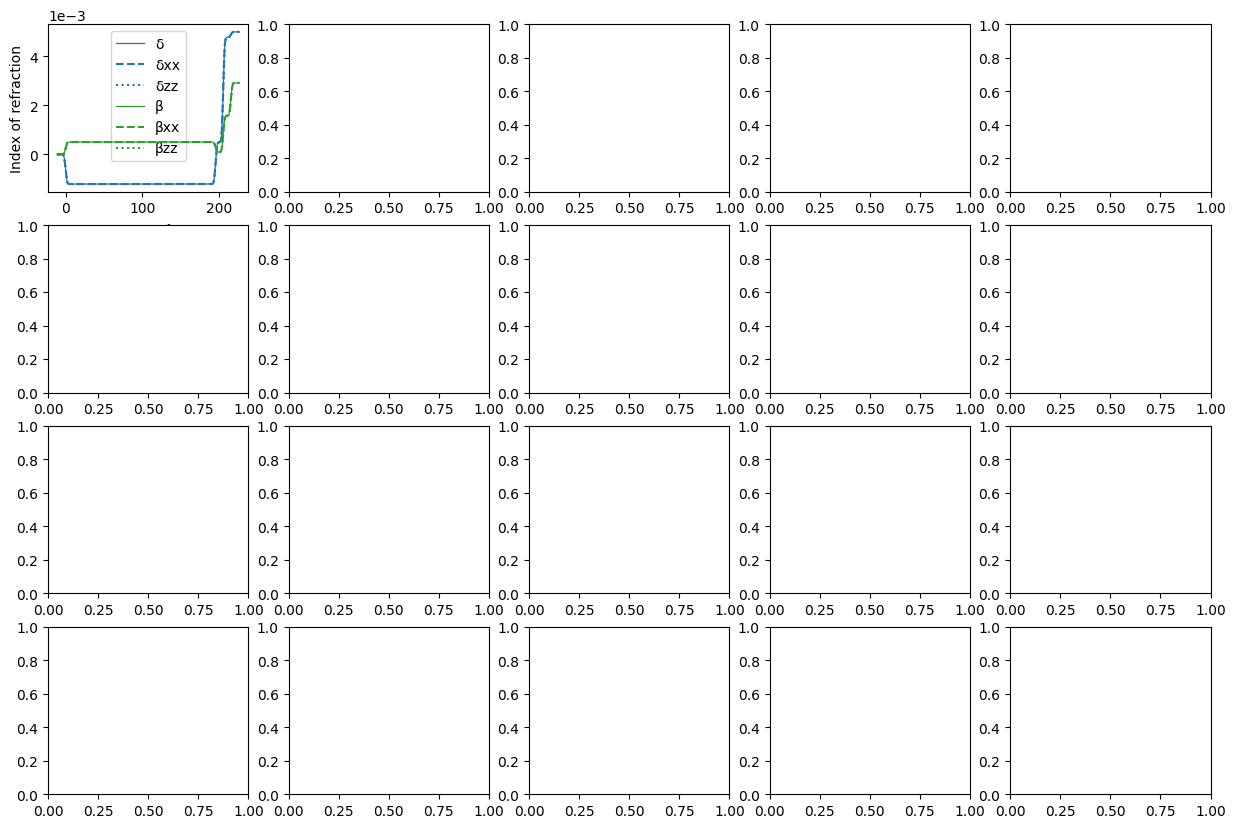

In [16]:
fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (15, 10))
from multiprocessing import Pool

ax = ax.flatten()
for i, s in enumerate(stacks.values()):
    s.plot(ax = ax[i])

In [25]:
from refnx.analysis import Transform, GlobalObjective
from refnx._lib.emcee.moves import DEMove
import pickle as pk
import warnings

warnings.filterwarnings('ignore')

demove = [DEMove(1e-3), DEMove(1e-3, .9)]

def construct_model(en, quickfit = True, checkpoint = True):
    """Construct the model."""
    # check if the objective function is allready saved as a pickle
    if Path(f"global/homes/h/hdh/{en}.pickle").exists():
        with open(f'{energy[i]}.pickle', 'rb') as file:
            obj = pk.load(file)

    else: 
        model = fit.ReflectModel(
            stacks[en],
            pol="sp",
            energy=float(en),
            name=f"ZnPc Mono Layer {en}eV",
            theta_offset_s=1e-3,
            theta_offset_p=1e-3,
            scale_p=1.0,
            scale_s=1.0,
        )
        model.theta_offset_s.setp(vary=True, bounds=(-1, 1))
        model.theta_offset_p.setp(vary=True, bounds=(-1, 1))
        model.scale_p.setp(vary=True, bounds=(0.6, 1.2))
        model.scale_s.setp(vary=True, bounds=(0.6, 1.2))
        d = data[en]
        model.bkg.value = d.data[1].min()
        obj = fit.AnisotropyObjective(model, d, transform=Transform("logY"), ll_scale=0)
        
    lpe = fit.LogpExtra(obj)
    obj.logp_extra = lpe
    x0 = [p.value for p in obj.varying_parameters()]
    # fit the objective to retrieve a good set of parameters
    if quickfit:
        fitter = fit.CurveFitter(
            objective = obj,
        )
        try:
            fitter.fit("differential_evolution", target = "nlpost", workers=-1, x0 = [p.value for p in obj.varying_parameters()])
        except:
            fitter.fit("differential_evolution", target = "nlpost", workers=-1)
        fitter.initialise("jitter")
        fitter.sample(1000, nthin=10, pool = -1, skip_check=True)
    save = Path(f"{en}.pickle")
    with save.open("wb") as file:
        pk.dump(obj, file)
    return obj


In [26]:
objs = {en: construct_model(en, quickfit=True, checkpoint=False) for en in stacks}

-35.571351198391866: : 107it [02:14,  1.25s/it]
100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s]


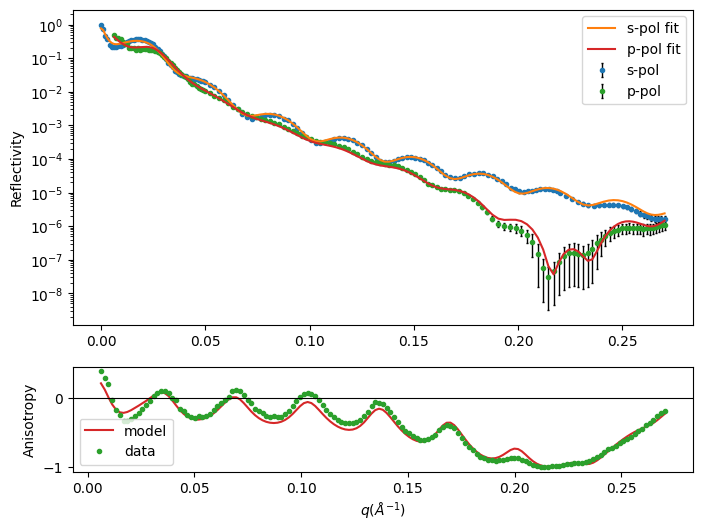

In [27]:
for o in objs.values():
    o.plot()

In [22]:
stacks = {k: cross_energy_constrain(s) if k != "283.7" else s for k, s in stacks.items()} 
objs = {en: construct_model(en, quickfit=False, checkpoint=False) if en != "283.7" else objs[en] for en in stacks}

In [23]:
obj = GlobalObjective([o for o in objs.values()])
fitter = fit.CurveFitter(obj)
fitter.fit("differential_evolution", target = "nlpost", workers=-1)

-602.57141400675: : 481it [1:54:27, 14.28s/it]   


             message: Optimization terminated successfully.
             success: True
                 fun: -602.57141400675
                   x: [ 8.171e-01  7.401e-01 ... -2.742e-05  1.477e-03]
                 nit: 481
                nfev: 1417671
          population: [[ 8.171e-01  7.401e-01 ... -2.742e-05  1.477e-03]
                       [ 8.401e-01  7.303e-01 ...  4.491e-04  1.443e-03]
                       ...
                       [ 7.866e-01  7.435e-01 ... -4.052e-04  1.286e-03]
                       [ 8.266e-01  7.492e-01 ... -1.598e-04  1.510e-03]]
 population_energies: [-6.026e+02 -5.753e+02 ... -5.719e+02 -5.792e+02]
               covar: [[ 7.748e-05  4.338e-05 ... -1.143e-07 -2.181e-07]
                       [ 4.338e-05  5.829e-05 ... -1.216e-07 -2.152e-07]
                       ...
                       [-1.143e-07 -1.216e-07 ...  7.679e-07 -1.635e-07]
                       [-2.181e-07 -2.152e-07 ... -1.635e-07  5.815e-08]]
              stderr: [ 8.802e-03 

In [24]:
fitter = fit.CurveFitter(obj, pool = -1)
fitter.sample(1000, nthin=10, pool = -1, skip_check=True)

save = Path(f"{en}.pickle")
with save.open("wb") as file:
    pk.dump(obj, file)

100%|██████████| 1000/1000 [1:16:28<00:00,  4.59s/it]


6 6


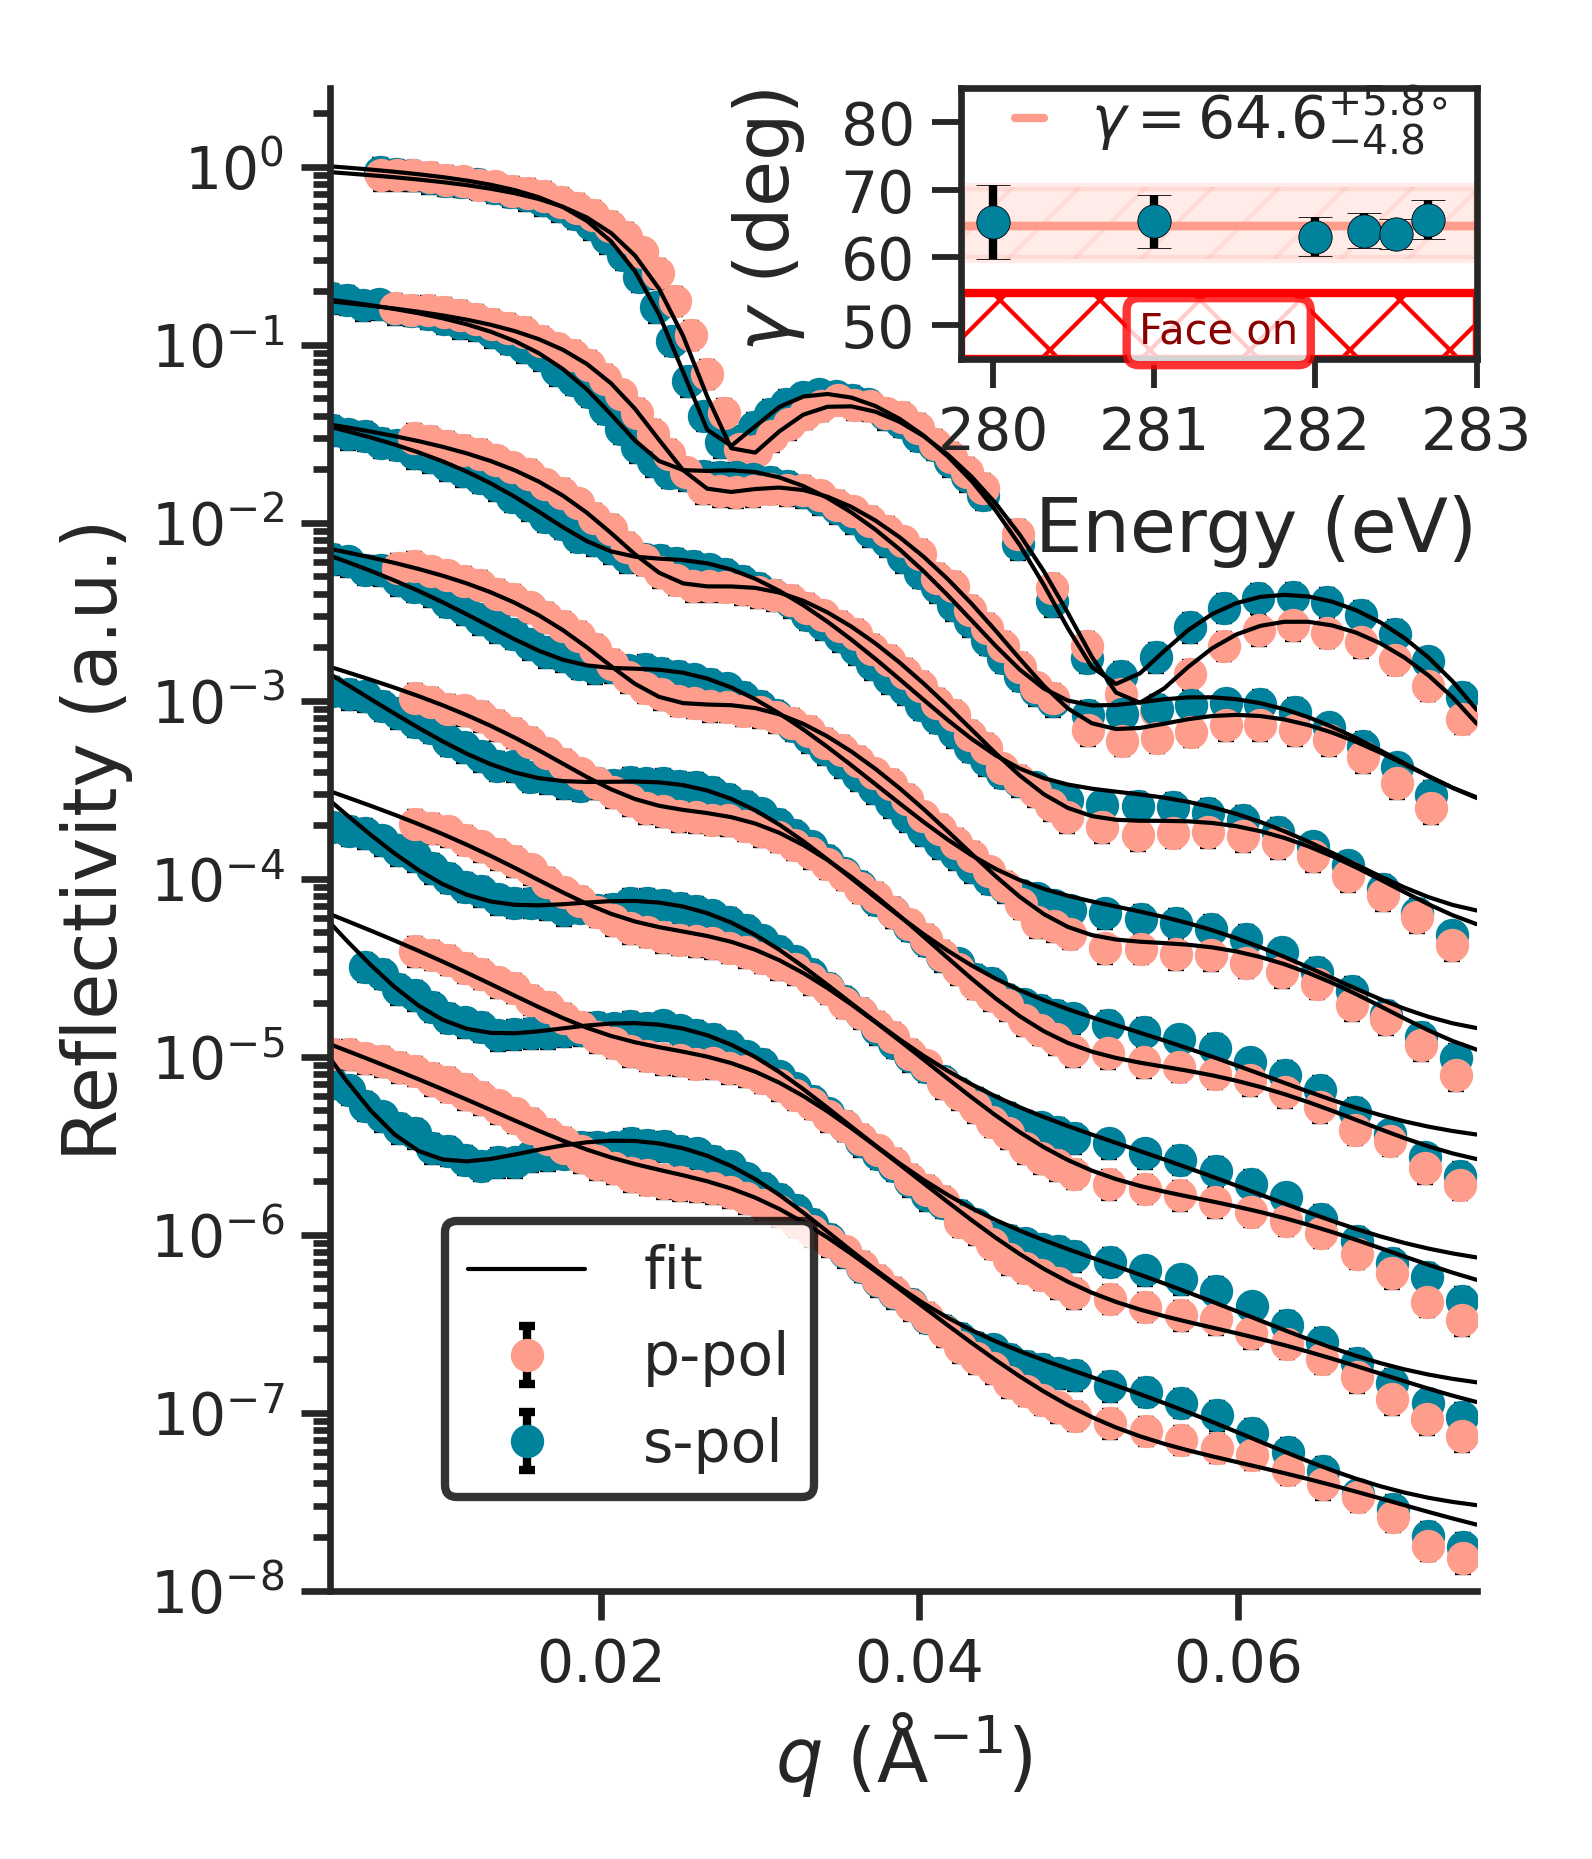

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

ZNPC = "C32H16N8Zn"
MA = np.asin(np.sqrt(2 / 3))

# Set up the styling
plt.rcParams.update({
    "figure.dpi": 600,
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 9,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "lines.linewidth": 1,
    "axes.linewidth": 0.8,
    "hatch.linewidth": 0.5
})

sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
colors = sns.color_palette("blend:#00829c,#ff9d8d", n_colors=3)

sns.set_palette("blend:#00829c,#ff9d8d", n_colors=2)
q = np.linspace(0.001, 0.075)
fig, ax = plt.subplots(figsize=(2.5, 3)) 
rotations = []
used_energy = [] 
for i, e in enumerate(energy):
    d = data[str(float(e))]
    if not Path(f"{str(float(e))}.pickle").exists():
        continue
    with open(f"{str(float(e))}.pickle", "rb") as f:
        _fitter = pk.load(f)
    model = _fitter.objective.model
    rotations.append(model.structure[1].sld.rotation)
    used_energy.append(e)
    
    model_s = fit.ReflectModel(
                model.structure,
                energy= e,
                pol = 's',
                name='',
                scale_s=model.scale_s,
                scale_p=model.scale_p,
                bkg=model.bkg,
                dq=model.dq,
                q_offset=model.q_offset,
                en_offset=model.en_offset,
                theta_offset_s=model.theta_offset_s,
                theta_offset_p=model.theta_offset_p,
                phi=0,
                backend='uni',
            )(q)
    model_p = fit.ReflectModel(
                model.structure,
                energy= e,
                pol = 'p',
                name='',
                scale_s=model.scale_s,
                scale_p=model.scale_p,
                bkg=model.bkg,
                dq=model.dq,
                q_offset=model.q_offset,
                en_offset=model.en_offset,
                theta_offset_s=model.theta_offset_s,
                theta_offset_p=model.theta_offset_p,
                phi=0,
                backend='uni',
            )(q)
    ax.errorbar(
                d.s.x,
                d.s.y*5**-i,
                d.s.y_err*5**-i,
                marker="o",
                color="C0",
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                label = "s-pol" if i == 1 else None,
                zorder = -1
        )
    ax.errorbar(
                d.p.x,
                d.p.y*5**-i,
                d.p.y_err*5**-i,
                marker="o",
                color="C1",
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                label = "p-pol" if i == 1 else None,
                zorder = -1
        )
    ax.plot(q, model_s*5**-i, color = "k", lw = .5, zorder = 2, label = "fit" if i == 1 else None)
    ax.plot(q, model_p*5**-i, color = "k", lw = .5, zorder = 2)
    
# Main plot formatting
ax.set_yscale("log")
ax.set_xlim(0.003, 0.075)
ax.set_ylim((1e-8))
ax.set_xlabel(r"$q\ (\mathrm{\AA}^{-1})$", labelpad=2)
ax.set_ylabel("Reflectivity (a.u.)", labelpad=2)
ax.tick_params(axis='both', which='both', pad=2, width=0.8)

# Improve legend positioning and content
handles, labels = ax.get_legend_handles_labels()
order = [0, 2, 1]  # Reorder: s-pol, fit, p-pol
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          loc=(.1, .0625), handletextpad=1,
          edgecolor="k",
         )

# Create professional inset axis
ax_inset = ax.inset_axes([0.55, 0.82, 0.45, 0.18],  # x, y, width, height
                        facecolor='white')
# sns.despine(ax=ax_inset, left=True, bottom=True, top=False, right=False)  # Remove left/bottom spines
# Then manually adjust remaining spines
# ax_inset.spines['top'].set_visible(True)
# ax_inset.spines['right'].set_visible(True)
# # ax_inset.spines['top'].set_position(('outward', 2))  # 5pt offset
# ax_inset.spines["top"].set_bounds(280, 283)
# # ax_inset.spines['right'].set_position(('outward', 2))
# ax_inset.spines["right"].set_bounds(50, 80)

# Ensure ticks are properly aligned
# ax_inset.xaxis.set_ticks_position('top')
# ax_inset.yaxis.set_ticks_position('right')

# Process rotations data
deg = np.rad2deg([r.value for r in rotations[2:]])
deg_err = 2 * np.rad2deg([r.stderr for r in rotations[2:]])
x_data = energy[2:]

# Calculate statistics
avg = np.average(deg, weights=deg_err)
ubound = deg + deg_err
lbound = deg - deg_err

q2 = np.quantile(np.concat([deg, ubound, lbound]), .99)
q1 = np.quantile(np.concat([deg, ubound, lbound]), .01)
pos_err = q2 - avg
neg_err = avg - q1
# Using proper error notation with phantom spacing
# Plot inset data
ax_inset.axhline(avg, color="C1", lw=1)

ax_inset.axhline(avg, color="C1", lw=1, label=fr"$\gamma = {avg:.1f}^{{+{pos_err:.1f}}}_{{-{neg_err:.1f}}}\!^\circ$")
ax_inset.axhspan(q1, q2, alpha=0.2, color="C1", hatch='///', )

if 'MA' in locals():
    ma_deg = np.rad2deg(MA)
    ax_inset.axhspan(45, ma_deg, hatch="xx", facecolor="none", ec="red", )
ax_inset.annotate("Face on", xy=(0.5, 0.2), xytext=(0.5, 0.1),
    xycoords='axes fraction', ha='center', va='center',
    fontsize=5, color='darkred', 
    bbox=dict(boxstyle='round', fc='white', ec='red', alpha=0.8))

# Inset styling
# Axis formatting
ax_inset.set_xlim(279.8, 283)
ax_inset.set_ylim(45, 85)
ax_inset.xaxis.set_major_locator(MaxNLocator(4, steps=[1,2,5]))
ax_inset.yaxis.set_major_locator(MaxNLocator(4))
ax_inset.set_xlabel("Energy (eV)", loc = "right")
ax_inset.set_ylabel(r"$\gamma$ (deg)", loc="top")
ax_inset.tick_params(axis='both', which='major', pad=2, width=0.7)
print(len(x_data), len(deg))
eb = ax_inset.errorbar(x_data, 
    deg, 
    yerr=deg_err,
    fmt='o', 
    ms=4,  # Increased marker size
    mfc=colors[0], 
    mec='k', 
    mew=0.1,  # Thicker marker edge
    ecolor='k', 
    elinewidth=1, 
    capsize=2, 
    capthick=0.8,
    zorder=10  # Ensure top layer
                      )

# Minimal legend
leg = ax_inset.legend(loc=(.06, .66), frameon=False, handlelength=.5)

# Final polish
plt.subplots_adjust(right=0.85)
sns.despine(ax=ax)
plt.tight_layout(pad=0.8)
plt.subplots_adjust(right=0.98, top=0.98)  # Fine-tune spacing

plt.show()
fig.savefig("xrr_angles.png", 
           dpi=900,  # Higher resolution for manuscript
           bbox_inches='tight',  # Automatically adjust boundaries
           pad_inches=0.05,  # Add small padding
           transparent=False)

In [62]:
def print_params(obj):
    vps = obj.varying_parameters()
    scales  = []
    theta = []
    surface = []
    znpc = []
    cont = [] 
    oxide = []
    for p in vps:
        if p.name.startswith("scale"):
            scales.append(p.__str__())
        if p.name.startswith("theta"):
            theta.append(p.__str__())
        if p.name.startswith("Surface"):
            surface.append(p.__str__())
        if p.name.startswith("ZnPc"):
            znpc.append(p.__str__())
        if p.name.startswith("Contamination"):
            cont.append(p.__str__())
        if p.name.startswith("Oxide"):
            oxide.append(p.__str__())

    print("Scale factors")
    print("\n".join(scales))
    print("Scale factors")
    print("\n".join(theta))
    print("Scale factors")
    print("\n".join(surface))
    print("Scale factors")
    print("\n".join(znpc))
    print("Scale factors")
    print("\n".join(cont))
    print("Scale factors")
    print("\n".join(oxide))

print_params(obj)

Scale factors
<Parameter:   'scale_s'   , value=0.999872 +/- 0.00123, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=0.999884 +/- 0.000836, bounds=[0.6, 1.2]>
<Parameter:   'scale_s'   , value=0.999951 +/- 0.000495, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=0.999933 +/- 0.000612, bounds=[0.6, 1.2]>
<Parameter:   'scale_s'   , value=1.00001 +/- 0.000515, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=0.999993 +/- 0.000523, bounds=[0.6, 1.2]>
<Parameter:   'scale_s'   , value=0.999954 +/- 0.00047, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=1.00013 +/- 0.0011, bounds=[0.6, 1.2]>
<Parameter:   'scale_s'   , value=0.999923 +/- 0.000728, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=1.00003 +/- 0.000531, bounds=[0.6, 1.2]>
<Parameter:   'scale_s'   , value=0.999896 +/- 0.000938, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=1.00001 +/- 0.000422, bounds=[0.6, 1.2]>
<Parameter:   'scale_s'   , value=1.00001 +/- 0.000467, bounds=[0.6, 1.2]>
<Parame

100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


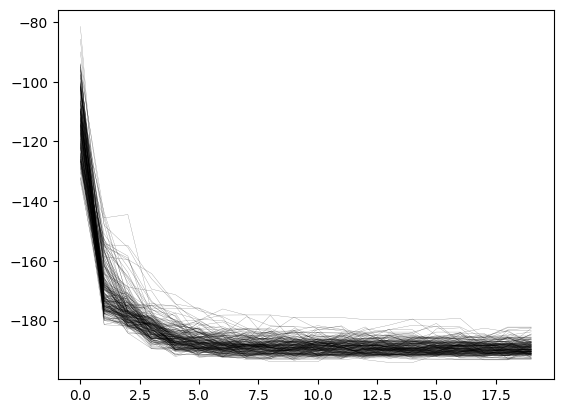

100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


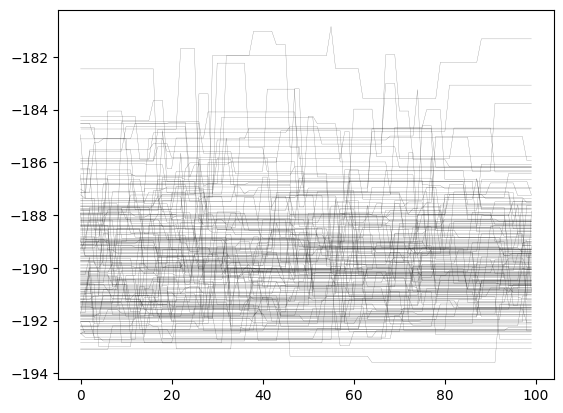

100%|██████████| 1000/1000 [05:29<00:00,  3.04it/s]


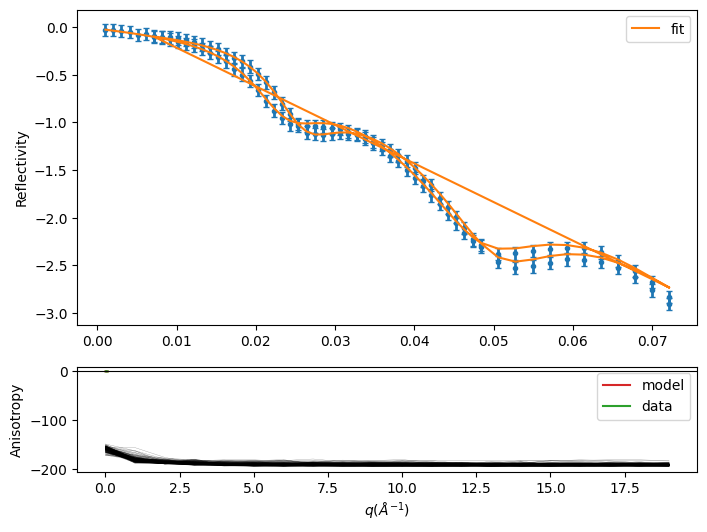

100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


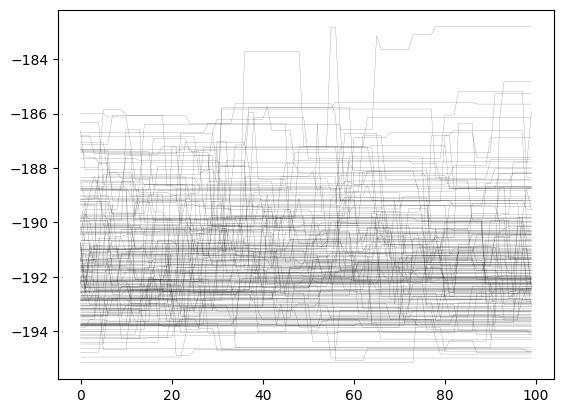

100%|██████████| 1000/1000 [06:04<00:00,  2.75it/s]


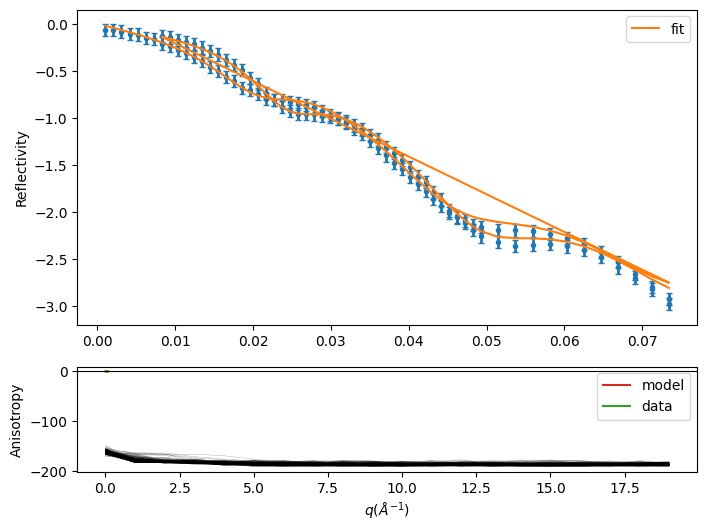

100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


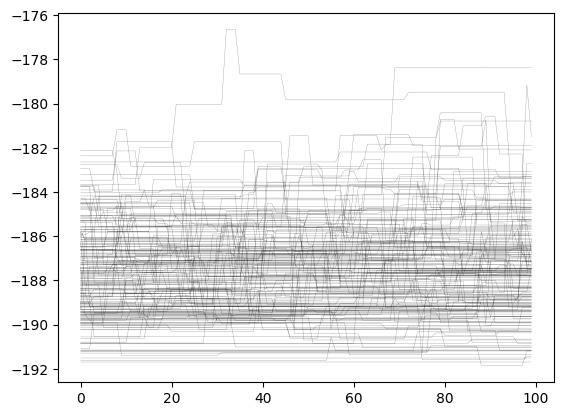

100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


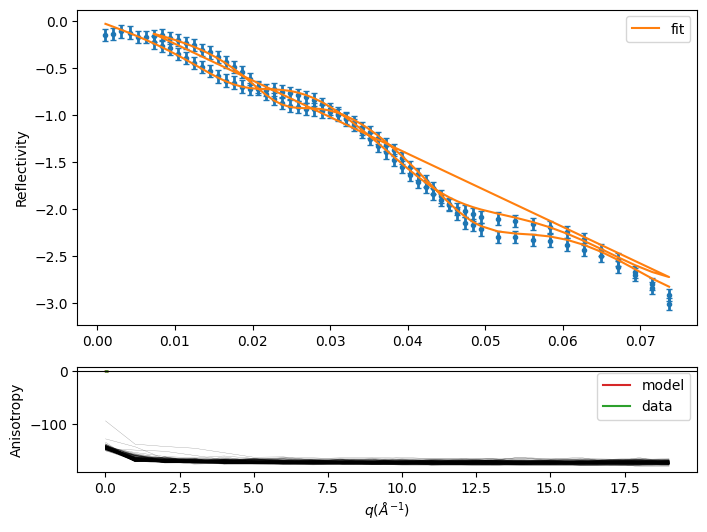

100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


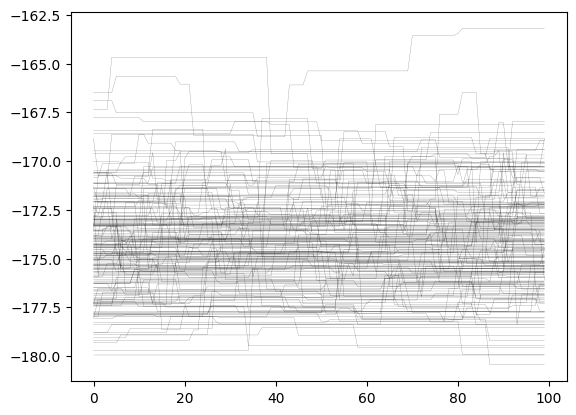

100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]


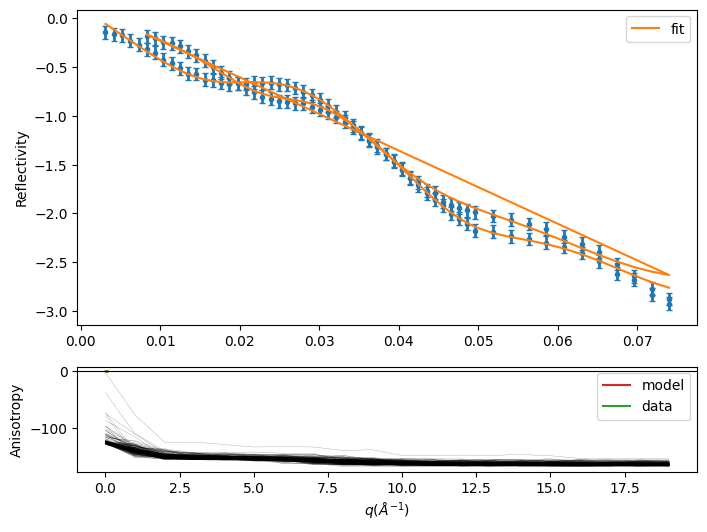

100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


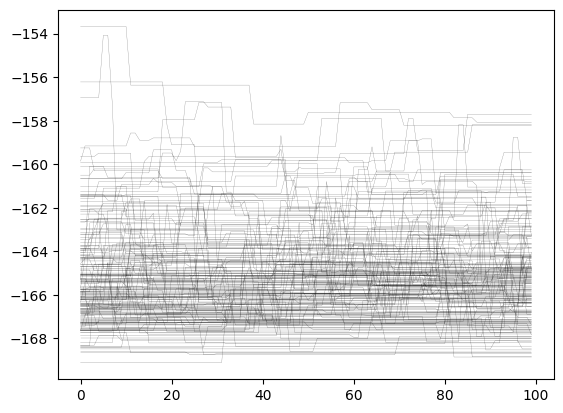

100%|██████████| 1000/1000 [05:24<00:00,  3.08it/s]


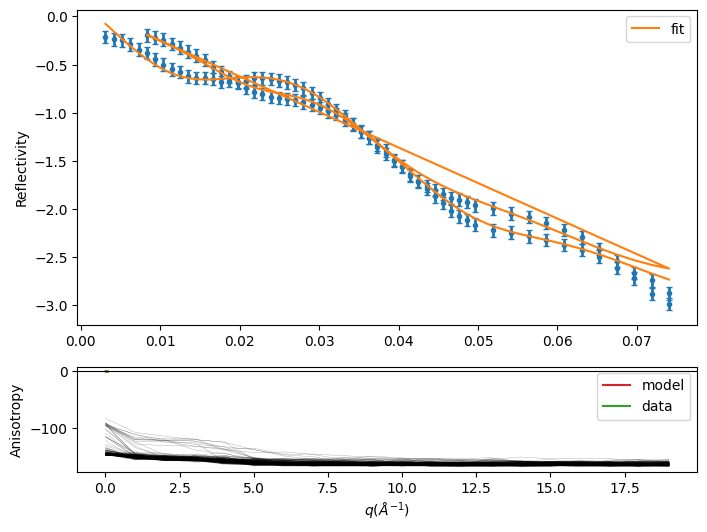

100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


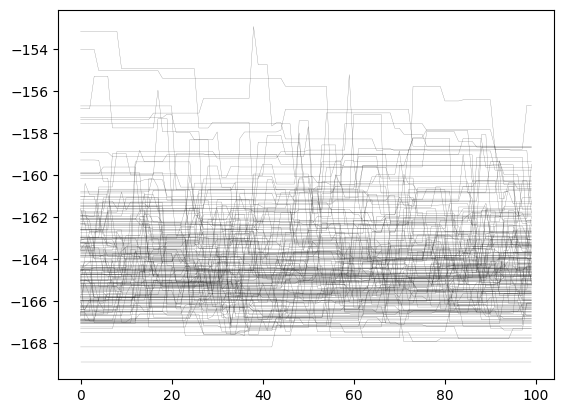

100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


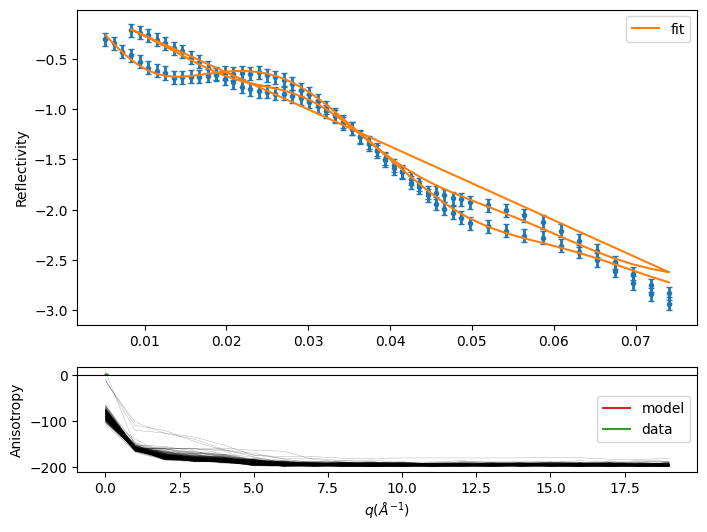

100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


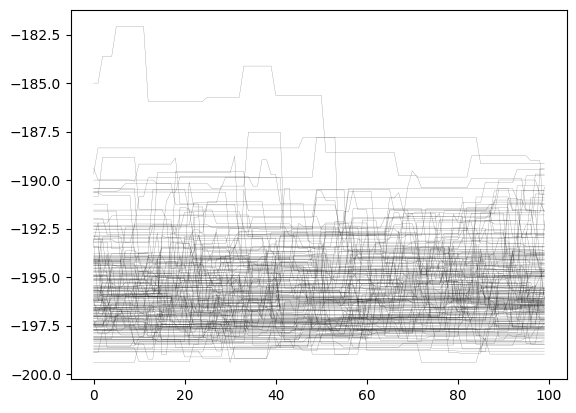

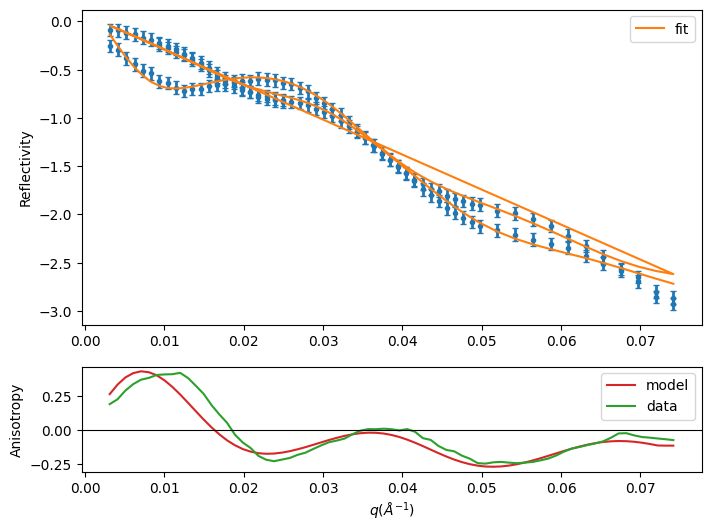

In [10]:
from multiprocessing import Pool

rotations = []

for i, o in enumerate(objs):
    if i==0:
        continue
    with Pool() as pool:
        fitter = fit.CurveFitter(
            objective = o,
            moves=fit.demove,
            pool = pool
        )
        fitter.initialise("jitter")
        chain = fitter.sample(1000, skip_initial_state_check=True, nthin = 50)
        plt.plot(-fitter.logpost, c="black", lw=0.2, alpha=0.5)
        plt.show()
        fitter.initialise("jitter")
        chain = fitter.sample(500, skip_initial_state_check=True, nthin = 10)
        fitter.reset()
        chain = fitter.sample(100, skip_initial_state_check=True)
        plt.plot(-fitter.logpost, c="black", lw=0.2, alpha=0.5)
        plt.show()
    o.plot()
    if i>0:
        rotations.append(o.model.structure[1].sld.rotation)
    with open(f'{energy[i]}.pickle', 'wb') as file:
        pk.dump(fitter, file)
    del fitter

In [91]:
angles = []
bulk_thick = 201.942
bulk_rough = 5.7
contamination_rough = []

for i, e in enumerate(energy):
    if i == 0:
        continue
    with open(f"{str(e)}.pickle", "rb") as f:
        _fitter = pk.load(f)

    slab_structure = _fitter.objective.model.structure
    print(slab_structure.parameters)

________________________________________________________________________________
Parameters: 'Structure - 275.0'
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters:     '_slab'    
<Parameter:   '_thick'    , value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:   '_rough'    , value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:    '_rho'     , value=0  (fixed) , bounds=[0.0, 0.0]>
________________________________________________________________________________
Parameters:     'bulk'     
________________________________________________________________________________
Parameters:   'bulk_slab'  
<Parameter: 'bulk_thick'  , value=191.004 +/- 6.54 , bounds=[150.0, 250.0], constraint=<Parameter:     None      , value=191.004  (fixed) , bounds=None>>
<Parameter: 'bulk_rough'  , value=5.7   +/- 0  , bounds=[0.0, 15.232759999999999], constraint=<Para

NameError: name 'rotations' is not defined

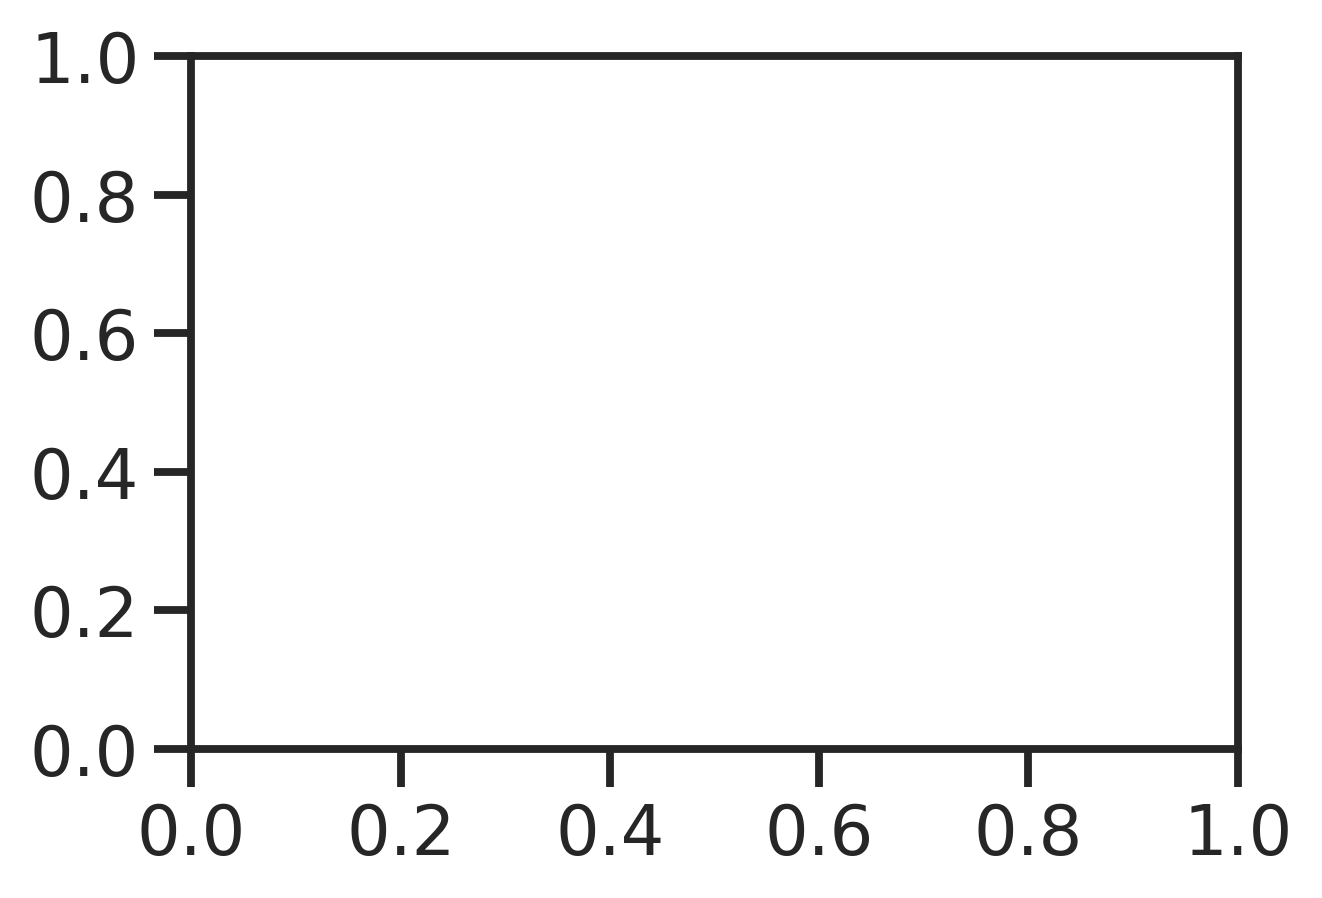

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Set up the styling
plt.rcParams.update({"figure.dpi": 300})
sns.set_context("talk")
sns.set_style("ticks")
colors = sns.color_palette("blend:#00829c,#ff9d8d", n_colors=2)

# Create figure
fig, ax = plt.subplots(figsize=(4.5, 3))

# Your data
deg = np.rad2deg([r.value for r in rotations][1:])
deg_err = 2*np.rad2deg([r.stderr for r in rotations][1:])
x_data = energy[2:]

# Calculate statistics
avg = np.average(deg, weights=deg_err)
ubound = deg + deg_err
lbound = deg - deg_err

q2 = np.quantile(np.concat([deg, ubound, lbound]), .99)
q1 = np.quantile(np.concat([deg, ubound, lbound]), .01)
pos_err = q2 - avg
neg_err = avg - q1

# Create error band
# ax.fill_between(x_data, deg - deg_err, deg + deg_err, 
#                 color=colors[0], alpha=0.3)

# Plot the data points with error bars
ax.errorbar(x_data, deg, deg_err, marker="o",
            color=colors[0], 
            ms=5,
            lw=0,
            ls=None,
            elinewidth=1,
            capsize=2,
            ecolor="k",)

# Add average and confidence interval
ax.axhline(avg, label=fr"$\langle \gamma \rangle$: {avg:.1f}°", 
           c=colors[1], lw=1.5, zorder=0)

# Add confidence region with hatching
ax.axhspan(q1, q2, alpha=0.15, color=colors[1], 
           hatch='///', label=f"99% CI [{q1:.1f}°, {q2:.1f}°]")

# Add the other filled region if needed
x_range = np.linspace(250, 320)
if 'MA' in locals():
    ax.fill_between(x_range, 0, np.rad2deg(MA), 
                   hatch="xx", facecolor="none", ec="red", )

# Styling
ax.set_ylim(45, 90)
ax.set_xlim(279.5, 283)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.set_xlabel("Energy [eV]")
ax.set_ylabel(r"$\gamma$ [deg]")

# Create a cleaner legend with better positioning
legend = ax.legend(loc='upper center', fontsize="12")

# Add a subtle grid

# Add an annotation for the average value
ax.annotate("Face on region", 
            xy=(.5, 0),
            xytext=(.5, .1),          # Text positioned in lower center
            xycoords="axes fraction",
            bbox=dict(boxstyle="square", fc="white", ec="red", alpha=1),
            ha='center',                 # Horizontal alignment
            va='center',                 # Vertical alignment
            fontsize=10,
            fontweight='bold',
            color='darkred')

# Final touches
# sns.despine()
plt.tight_layout()

plt.show()

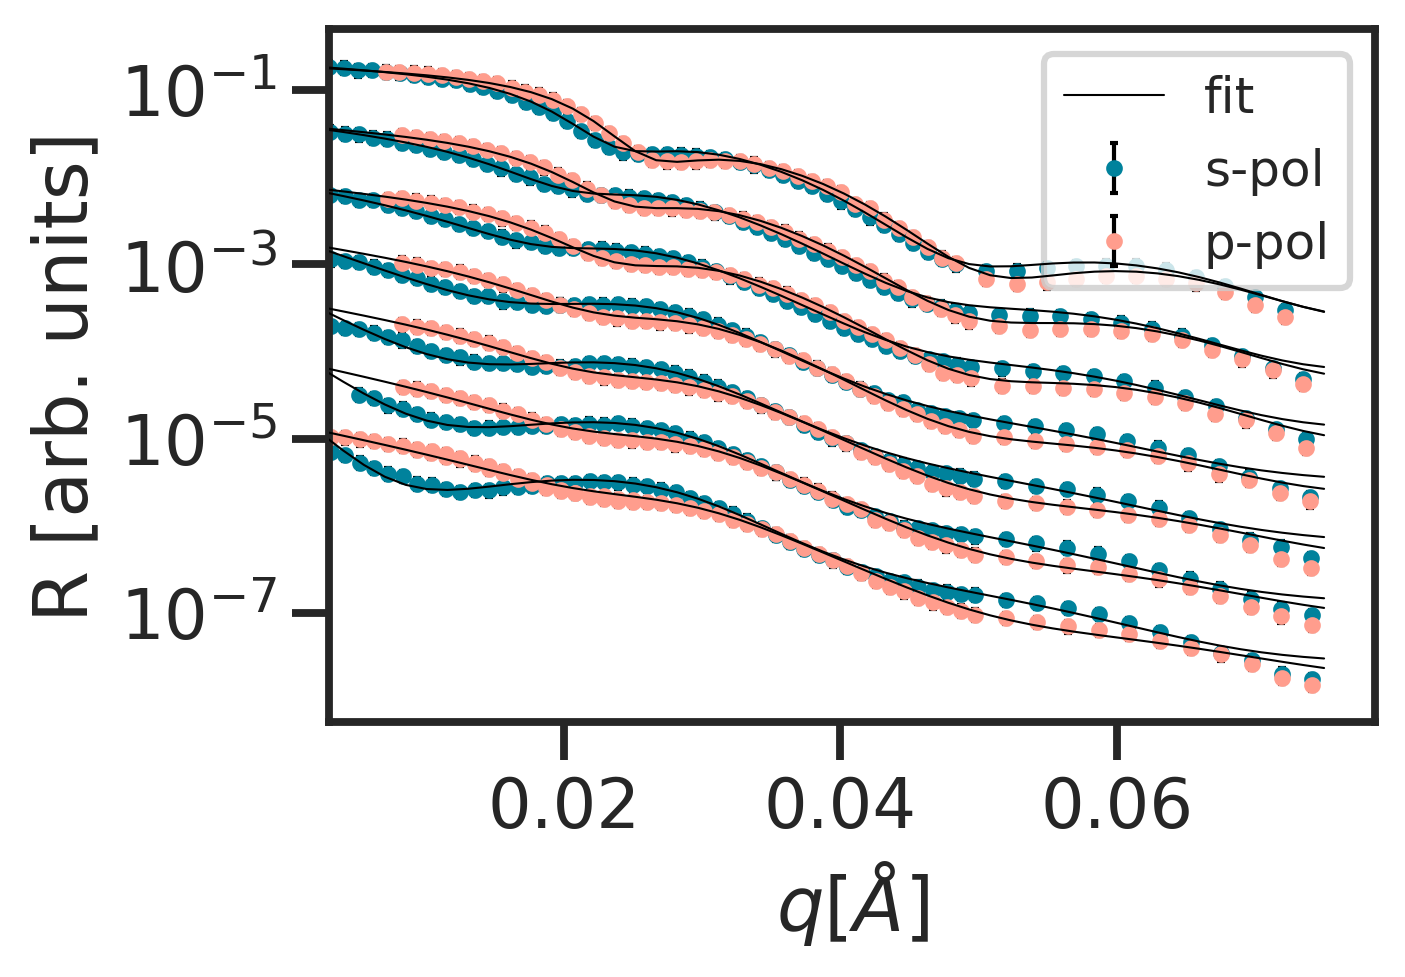

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Set up the styling
plt.rcParams.update({"figure.dpi": 300})
sns.set_context("talk")
sns.set_style("ticks")

sns.set_palette("blend:#00829c,#ff9d8d", n_colors=2)
q = np.linspace(0.001, 0.075)
fig, ax = plt.subplots(figsize = (4.5, 3))
for i, e in enumerate(energy):
    if i == 0:
        continue
    if i >=16:
        continue
    d = data[str(e)]
    with open(f"{str(e)}.pickle", "rb") as f:
        _fitter = pk.load(f)
    model = _fitter.objective.model
    model_s = fit.ReflectModel(
                model.structure,
                energy= e,
                pol = 's',
                name='',
                scale_s=model.scale_s,
                scale_p=model.scale_p,
                bkg=model.bkg,
                dq=model.dq,
                q_offset=model.q_offset,
                en_offset=model.en_offset,
                theta_offset_s=model.theta_offset_s,
                theta_offset_p=model.theta_offset_p,
                phi=0,
                backend='uni',
            )(q)
    model_p = fit.ReflectModel(
                model.structure,
                energy= e,
                pol = 'p',
                name='',
                scale_s=model.scale_s,
                scale_p=model.scale_p,
                bkg=model.bkg,
                dq=model.dq,
                q_offset=model.q_offset,
                en_offset=model.en_offset,
                theta_offset_s=model.theta_offset_s,
                theta_offset_p=model.theta_offset_p,
                phi=0,
                backend='uni',
            )(q)
    ax.errorbar(
                d.s.x,
                d.s.y*5**-i,
                d.s.y_err*5**-i,
                marker="o",
                color="C0",
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                label = "s-pol" if i == 1 else None
        )
    ax.errorbar(
                d.p.x,
                d.p.y*5**-i,
                d.p.y_err*5**-i,
                marker="o",
                color="C1",
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                label = "p-pol" if i == 1 else None
        )
    ax.plot(q, model_s*5**-i, color = "k", lw = .5, zorder = 10, label = "fit" if i == 1 else None)
    ax.plot(q, model_p*5**-i, color = "k", lw = .5, zorder = 10)
ax.set_yscale("log")
ax.set_xlim((.003))
ax.set_xlabel(r"$q[\AA]$")
ax.set_ylabel("R [arb. units]")
ax.legend(fontsize = 12)

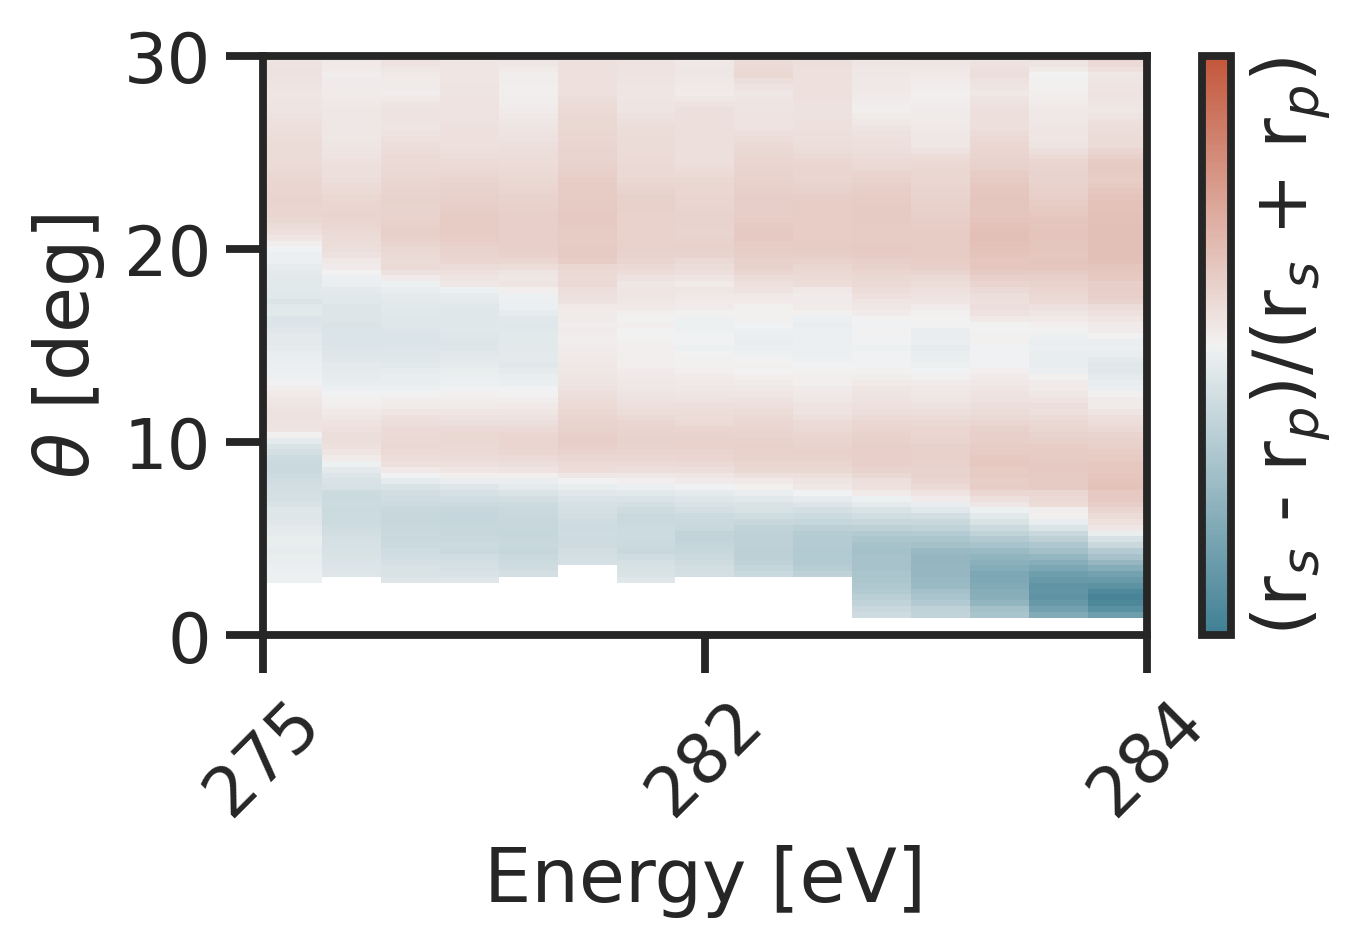

In [98]:
df = df if isinstance(df, pd.DataFrame) else df.to_pandas()
df["lambda"] = 12398.4193 / df["Beamline Energy [eV]"]
df["theta"] = 2 * (np.arcsin(df["Q"] * df["lambda"] / (4 * np.pi)) * 180 / np.pi).round(
    2
)

energies = energy_[1:16]

# First pass: find global min and max theta across all energies
global_theta_min = float('inf')
global_theta_max = float('-inf')

for e in energies:
    g = df[df["Beamline Energy [eV]"] == e]
    
    # Get theta values for each polarization
    theta_s = g["theta"].where(g["pol"] == "s").dropna().values
    theta_p = g["theta"].where(g["pol"] == "p").dropna().values
    
    # Update the global min and max
    global_theta_min = min(global_theta_min, theta_s.min(), theta_p.min())
    global_theta_max = max(global_theta_max, theta_s.max(), theta_p.max())

# Create a unified theta grid for all energies
num_theta_points = 100
unified_theta = np.linspace(global_theta_min, global_theta_max, num_theta_points)

# Initialize maps with correct size
r_s_map = np.zeros((num_theta_points, len(energies)))
r_model_s_map = np.zeros((num_theta_points, len(energies)))
r_p_map = np.zeros((num_theta_points, len(energies)))
r_model_p_map = np.zeros((num_theta_points, len(energies)))
ani_map = np.zeros((num_theta_points, len(energies)))
ani_model_map = np.zeros((num_theta_points, len(energies)))

# Second pass: interpolate data onto unified theta grid
for i, e in enumerate(energies):
    g = df[df["Beamline Energy [eV]"] == e]
    # with open(f"{str(e)}.pickle", "rb") as f:
    #     _fitter = pk.load(f)
    # model = _fitter.objective.model
    
    # Get theta values and r values for each polarization
    theta_s = g["theta"].where(g["pol"] == "s").dropna().values
    theta_p = g["theta"].where(g["pol"] == "p").dropna().values
    r_s = g["r"].where(g["pol"] == "s").dropna().values
    r_p = g["r"].where(g["pol"] == "p").dropna().values
    
    # Interpolate onto unified theta grid
    # Use np.interp with bounds_error=False and fill_value=np.nan to handle out-of-range values
    r_s_interp = np.interp(unified_theta, theta_s, r_s, left=np.nan, right=np.nan)
    r_p_interp = np.interp(unified_theta, theta_p, r_p, left=np.nan, right=np.nan)
    # unified_q = (4 * np.pi / (12398.4193 / e)) * np.sin(unified_theta / 2)
    # r_model_s = fit.ReflectModel(
    #             model.structure,
    #             energy= e,
    #             pol = 's',
    #             name='',
    #             scale_s=model.scale_s,
    #             scale_p=model.scale_p,
    #             bkg=model.bkg,
    #             dq=model.dq,
    #             q_offset=model.q_offset,
    #             en_offset=model.en_offset,
    #             theta_offset_s=model.theta_offset_s,
    #             theta_offset_p=model.theta_offset_p,
    #             phi=0,
    #             backend='uni',
    #         )(unified_q)
    # r_model_p = fit.ReflectModel(
    #             model.structure,
    #             energy= e,
    #             pol = 'p',
    #             name='',
    #             scale_s=model.scale_s,
    #             scale_p=model.scale_p,
    #             bkg=model.bkg,
    #             dq=model.dq,
    #             q_offset=model.q_offset,
    #             en_offset=model.en_offset,
    #             theta_offset_s=model.theta_offset_s,
    #             theta_offset_p=model.theta_offset_p,
    #             phi=0,
    #             backend='uni',
    #         )(unified_q)
    
    # Calculate anisotropy
    with np.errstate(invalid='ignore', divide='ignore'):
        ani = (r_s_interp - r_p_interp) / (r_s_interp + r_p_interp)
        # ani_model = (r_model_s - r_model_p) / (r_model_s + r_model_p)
    
    # Store in maps
    r_s_map[:, i] = r_s_interp
    r_p_map[:, i] = r_p_interp
    ani_map[:, i] = ani

# Create the plot
fig, ax = plt.subplots(figsize=(5,3.5))

# Use imshow with fixed colorbar range from -1 to 1
im = ax.imshow(
    ani_map,
    aspect="auto",
    origin="lower",
    interpolation="none",
    extent=[0, len(energies)-1, global_theta_min, global_theta_max],
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    vmin=-1,  # Set minimum value for colorbar
    vmax=1,   # Set maximum value for colorbar
)

# Set labels and title
title = "Anisotropy Map" if 'title' not in locals() else title
# ax.set_title(title)
ax.set_ylabel(r"$\theta$ [deg]")
ax.set_xlabel("Energy [eV]")

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("(r$_s$ - r$_p$)/(r$_s$ + r$_p$)")
cbar.set_ticks([])

# Set ticks for energy (x-axis)
n_energy_ticks = min(len(energies), 3)  # Limit number of ticks to avoid crowding
energy_indices = np.linspace(0, len(energies) - 1, n_energy_ticks, dtype=int)
ax.set_xticks(energy_indices)
ax.set_xticklabels([f"{energies[j]:.0f}" for j in energy_indices], rotation=45)

# Set ticks for theta (y-axis)
n_theta_ticks = 4
theta_ticks = np.linspace(global_theta_min, global_theta_max, n_theta_ticks)
ax.set_yticks(theta_ticks)
ax.set_yticklabels([f"{t:.0f}" for t in theta_ticks])

# Add grid for better readability
ax.grid(False)
plt.tight_layout()
plt.show()

________________________________________________________________________________
Parameters: 'Structure - 275.0'
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters:     '_slab'    
<Parameter:   '_thick'    , value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:   '_rough'    , value=0  (fixed) , bounds=[0.0, 0.0]>
<Parameter:    '_rho'     , value=0  (fixed) , bounds=[0.0, 0.0]>
________________________________________________________________________________
Parameters:     'bulk'     
________________________________________________________________________________
Parameters:   'bulk_slab'  
<Parameter: 'bulk_thick'  , value=191.004 +/- 6.54 , bounds=[150.0, 250.0], constraint=<Parameter:     None      , value=191.004  (fixed) , bounds=None>>
<Parameter: 'bulk_rough'  , value=5.7   +/- 0  , bounds=[0.0, 15.232759999999999], constraint=<Para

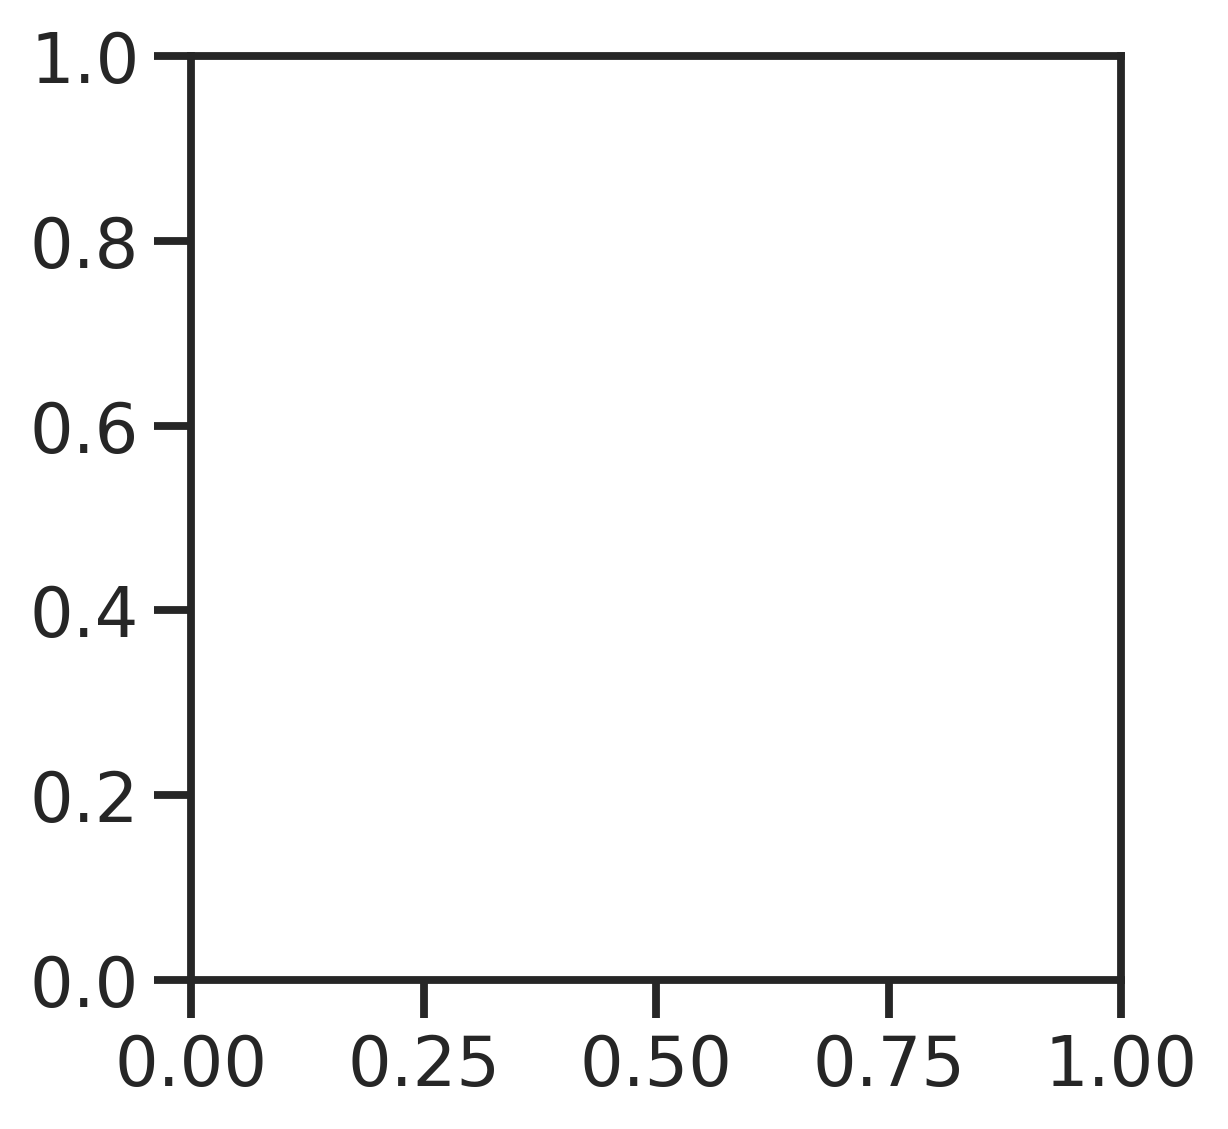

# Fit 250 eV alone

100%|██████████| 1000/1000 [20:15<00:00,  1.22s/it]


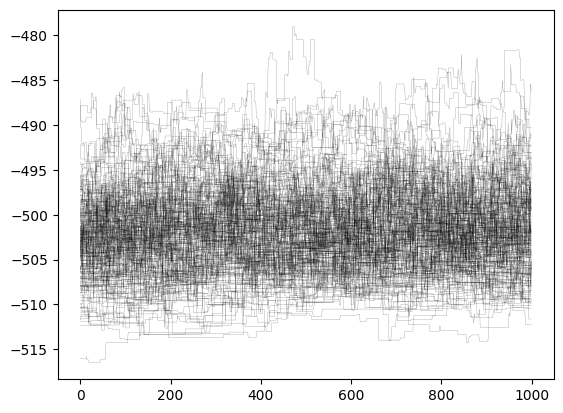

________________________________________________________________________________
Parameters:      None      
<Parameter:'bulk_enOffset', value=0   +/- 0  , bounds=[-0.2, 0.2]>
<Parameter: 'bulk_thick'  , value=187.584 +/- 0.251, bounds=[150.0, 250.0]>
<Parameter: 'bulk_rough'  , value=5.70914 +/- 0.179, bounds=[0.0, 15.232759999999999]>
<Parameter:'bulk_density' , value=1.31071 +/- 0.0149, bounds=[1.0, 2.0]>
<Parameter:'bulk_rotation', value=0.957581 +/- 0.00273, bounds=[0.9553166181245093, 1.5707963267948966]>
<Parameter:'contamination_thick', value=14.9674 +/- 0.0418, bounds=[0.0, 15.0]>
<Parameter:'contamination_rough', value=11.8894 +/- 0.0617, bounds=[0.0, 15.0]>
<Parameter:'contamination_rho', value=1.09349 +/- 0.0463, bounds=[1.0, 4.0]>
<Parameter: 'SiO2_thick'  , value=8.25419 +/- 0.172, bounds=[0.0, 20.0]>
<Parameter: 'SiO2_rough'  , value=6.53354 +/- 0.135, bounds=[0.0, 20.0]>


(<Axes: ylabel='Reflectivity'>,
 <Axes: xlabel='$q (\\AA^{-1})$', ylabel='Anisotropy'>)

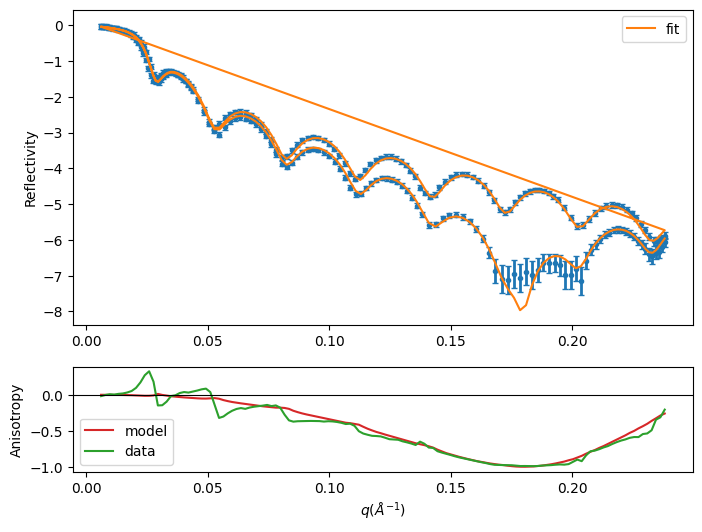

In [16]:
fitter.initialise("jitter")
chain = fitter.sample(2000, skip_initial_state_check=True, nthin = 10)
fitter.reset()
chain = fitter.sample(1000, skip_initial_state_check=True)
plt.plot(-fitter.logpost, c="black", lw=0.2, alpha=0.5)
plt.show()
print(objs["250.0"].varying_parameters())
objs["250.0"].plot()

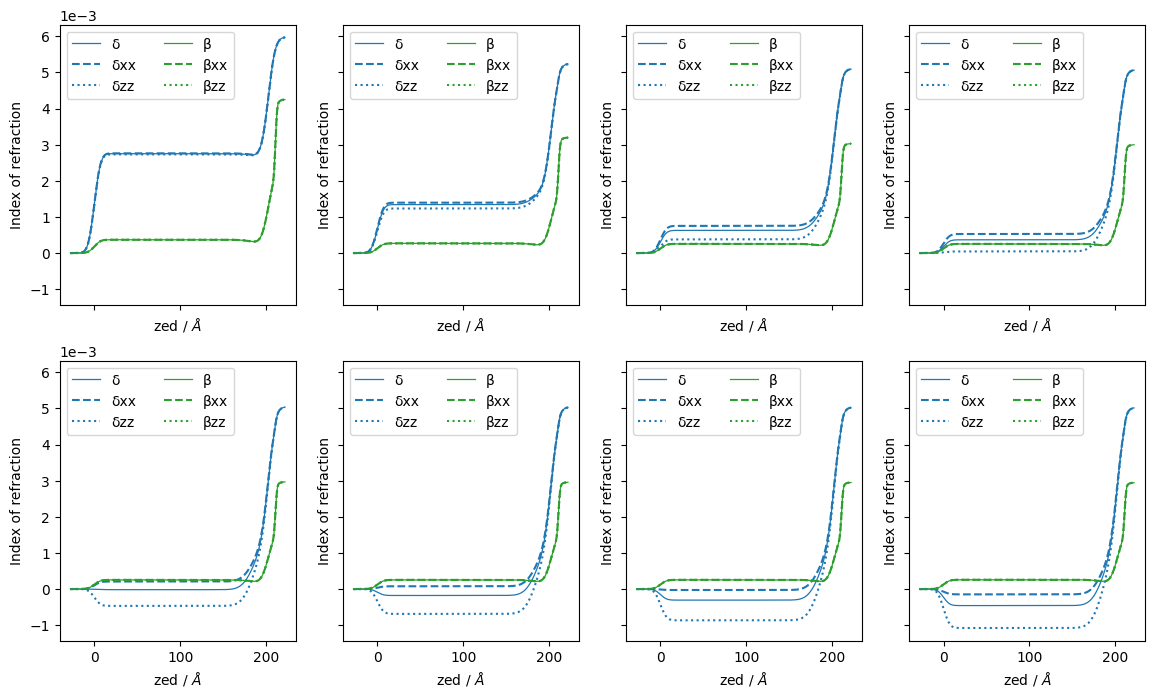

In [17]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (14, 8), sharex = True, sharey = True)
for i, a in enumerate(ax.flat):
    struct[i].plot(ax = a)
    a.legend(ncols=2)

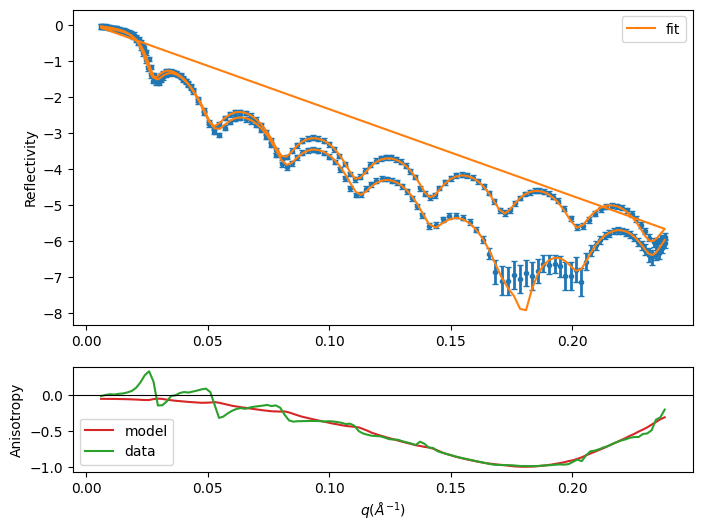

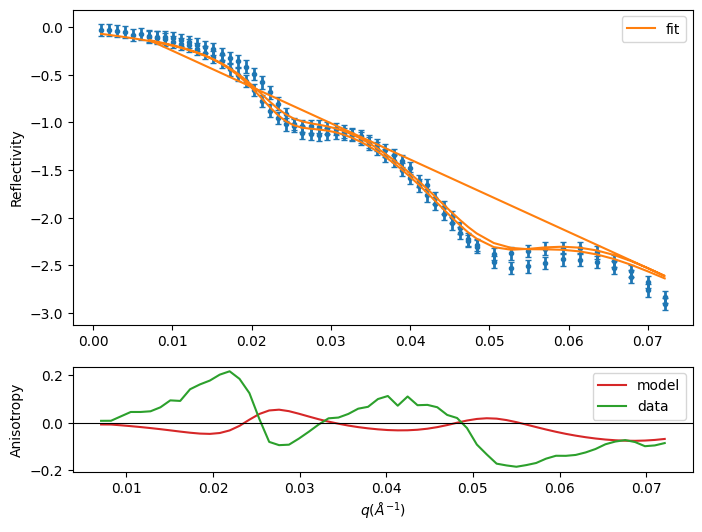

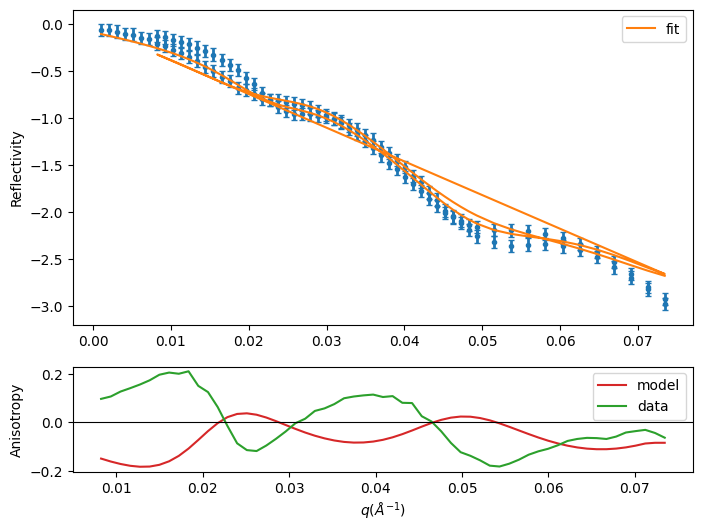

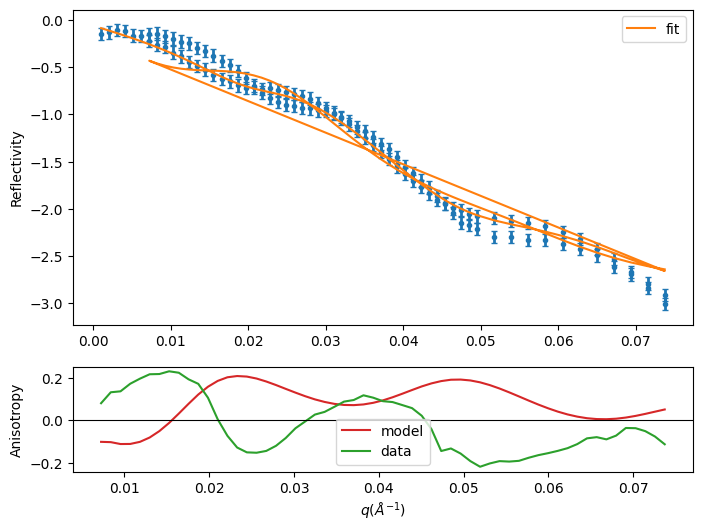

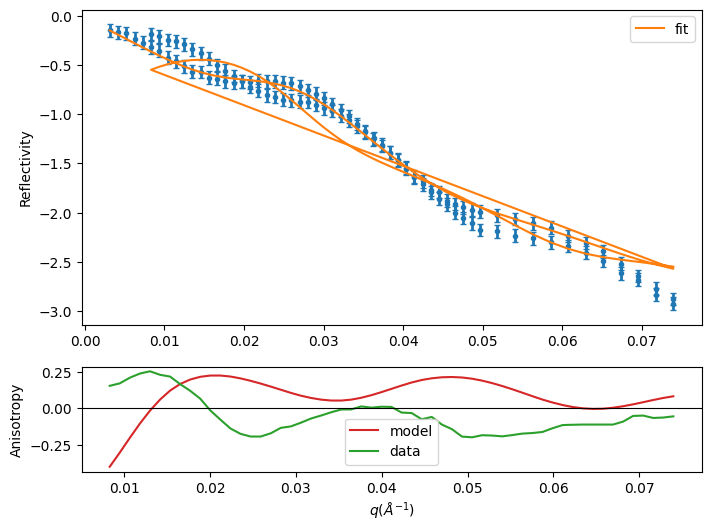

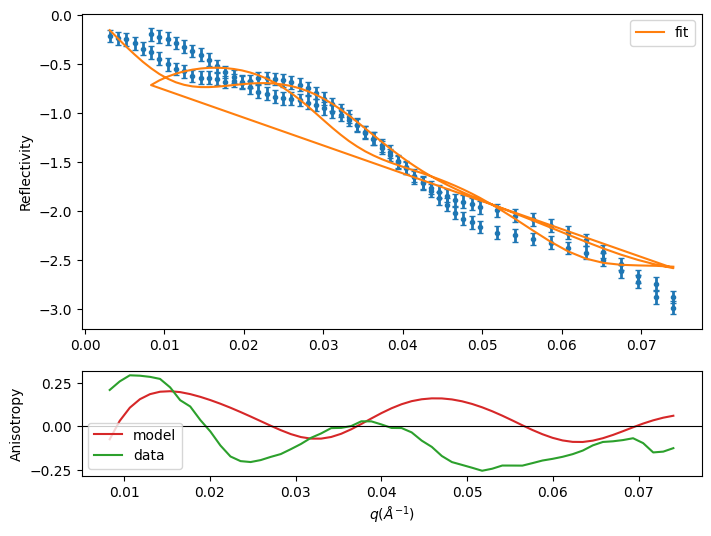

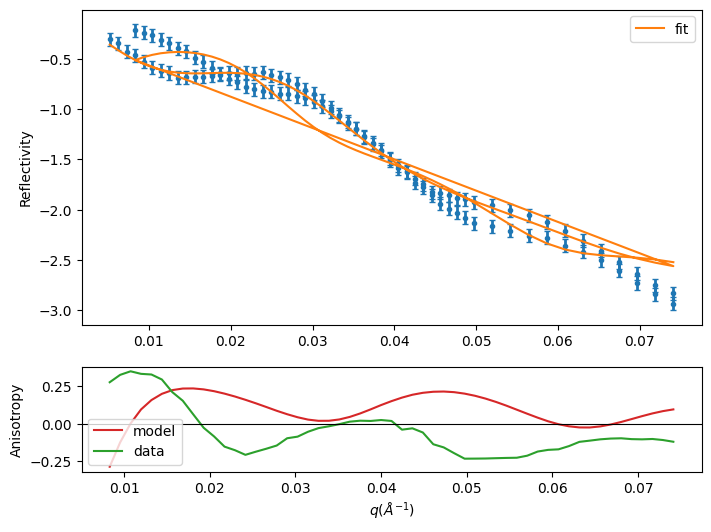

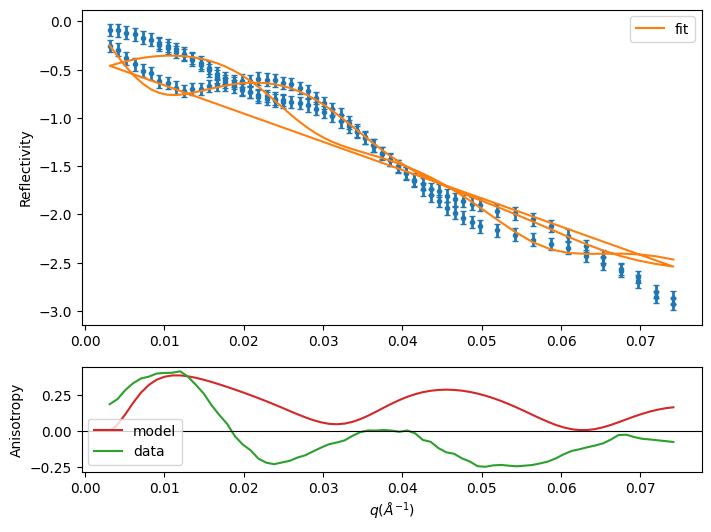

In [20]:
for e, o in objs.items():
    o.plot()

In [14]:
print(obj.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=0.879598 +/- 0.0239, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=0.985982 +/- 0.0274, bounds=[0.6, 1.2]>
<Parameter:'bulk_enOffset', value=0   +/- 0  , bounds=[-0.2, 0.2]>
<Parameter:'theta_offset_s', value=0.287895 +/- 0.0434, bounds=[-1.0, 1.0]>
<Parameter:'theta_offset_p', value=0.0503131 +/- 0.0388, bounds=[-1.0, 1.0]>
<Parameter: 'bulk_thick'  , value=202.525 +/- 0.291, bounds=[150.0, 250.0]>
<Parameter: 'bulk_rough'  , value=4.64259 +/- 0.264, bounds=[0.0, 15.232759999999999]>
<Parameter:  'bulk_rho'   , value=1.20095 +/- 0.0185, bounds=[1.0, 2.0]>
<Parameter: 'SiO2_thick'  , value=8.3825 +/- 0.156, bounds=[0.0, 20.0]>
<Parameter: 'SiO2_rough'  , value=6.64843 +/- 0.119, bounds=[0.0, 20.0]>
<Parameter:   'scale_s'   , value=0.842256 +/- 0.0405, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=0.931781 +/- 0.0445, bounds=[0.6, 

(<Figure size 640x480 with 1 Axes>, <Axes: >)

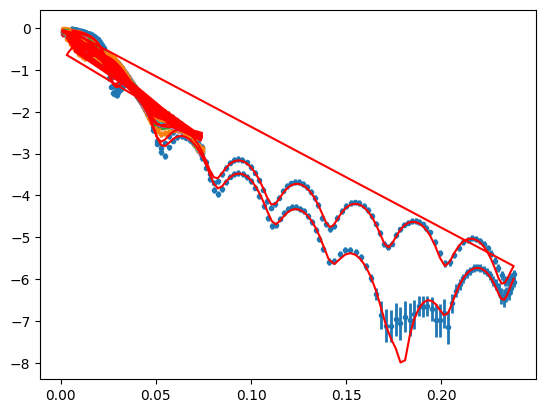

In [15]:
obj.plot()

In [12]:
with open('structure_283.7.pickle', 'wb') as file:
    pk.dump(fitter, file)

# Apply multi-energy Constraints

In [29]:
ibounds = (0, .01)
rbounds = (-.01, .01)

# set up parameter boundaries
for i, slab in enumerate(surf):
    slab.thick.setp(vary=True, bounds=(0, 2*(surf_thick + surf_rough)))
    slab.rough.setp(vary=True, bounds=(0, (surf_thick + surf_rough)))
    if i == 0:
        slab.sld.density.setp(vary = True, bounds = (0, 1.5))
    else:
        slab.sld.xx.setp(vary=True, bounds = rbounds)
        slab.sld.zz.setp(vary=True, bounds = rbounds)
        slab.sld.ixx.setp(vary=True, bounds = ibounds)
        slab.sld.izz.setp(vary=True, bounds = ibounds)

# Bulk constraint
for i, slab in enumerate(bulk):
    slab.thick.setp(vary=True, bounds=(100, 250))
    slab.rough.setp(vary=False, bounds=(0, (surf_thick + surf_rough)))
    if i == 0:
        slab.sld.density.setp(vary = True, bounds = (1, 2))
    else:
        slab.sld.rotation.setp(vary=True, bounds = (np.pi/4, np.pi/2))

for i, slab in enumerate(inter):
    vary = True if i in [0, j] else None
    thick_constraint = None if i == 0 else bulk[0].thick - surf[]
    rough_constraint = None if i == 0 else bulk[0].rough
    
    slab.thick.setp(vary=True, bounds=(0, 2*(patern_thick + patern_rough)))
    slab.rough.setp(vary=True, bounds=(0, (patern_thick + patern_rough)))
    if i == 0:
        slab.sld.density.setp(vary = True, bounds = (0, 2))
    else:
        slab.sld.xx.setp(vary=True, bounds = rbounds)
        slab.sld.zz.setp(vary=True, bounds = rbounds)
        slab.sld.ixx.setp(vary=True, bounds = ibounds)
        slab.sld.izz.setp(vary=True, bounds = ibounds)

# substrate parameters

for i, slab in enumerate(sio2):
    vary = True if i == 0  else None
    thick_constraint = None if i == 0 else sio2[0].thick
    rough_constraint = None if i == 0 else sio2[0].rough
    slab.thick.setp(vary=vary, bounds = (0, 15), constraint=thick_constraint)
    slab.rough.setp(vary=vary, bounds = (0, 10), constraint=rough_constraint)
    slab.sld.density.setp(vary=False)

for slab in si:
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)

for slab in vac:
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)

Structure(components=[Slab(Parameter(value=0.0, name='_thick', vary=False, bounds=Interval(lb=0.0, ub=0.0), constraint=None), MaterialSLD('', Parameter(value=0.0, name='_rho', vary=False, bounds=Interval(lb=0.0, ub=0.0), constraint=None),energy=250.0, wavelength=49.59367937419316, name=''), Parameter(value=0.0, name='_rough', vary=False, bounds=Interval(lb=0.0, ub=0.0), constraint=None), name='',, Slab(Parameter(value=201.9596477066441, name='bulk_thick', vary=True, bounds=Interval(lb=100.0, ub=250.0), constraint=None), MaterialSLD('C32H16N8Zn', Parameter(value=1.429242107096387, name='bulk_rho', vary=True, bounds=Interval(lb=1.0, ub=2.0), constraint=None),energy=250.0, wavelength=49.59367937419316, name='bulk'), Parameter(value=5.71319663114196, name='bulk_rough', vary=True, bounds=Interval(lb=0.0, ub=17.05568), constraint=None), name='bulk',, Slab(Parameter(value=9.187595995643255, name='SiO2_thick', vary=True, bounds=Interval(lb=0.0, ub=15.0), constraint=None), MaterialSLD('SiO2', P

In [ ]:
def constrain_energy(en):
    en = str(en)
    stack = stacks[en]
        # return
    stack[1].thick.constraint = None
    stack[1].rough.constraint = None
    stack[1].thick.setp(vary=False, value=loaded_structure[1].thick.value)
    stack[1].rough.setp(vary=False, value=loaded_structure[1].rough.value)

    stack[2].thick.constraint = None
    stack[2].rough.constraint = None
    stack[2].thick.setp(vary=False, value=loaded_structure[2].thick.value)
    stack[2].rough.setp(vary=False, value=loaded_structure[2].rough.value)
    stack[2].sld.density.constraint = None
    stack[2].sld.density.setp(value = loaded_structure[2].sld.density.value)
    stack[2].sld.energy_offset.setp(value=0, vary=True, bounds = (-.2, .2))

    stack[3].thick.constraint = None
    stack[3].rough.constraint = None
    stack[3].thick.setp(vary=False, value=loaded_structure[3].thick.value)
    stack[3].rough.setp(vary=False, value=loaded_structure[3].rough.value)

    stack[4].thick.constraint = None
    stack[4].rough.constraint = None
    stack[4].thick.setp(vary=False, value=loaded_structure[4].thick.value)
    stack[4].rough.setp(vary=False, value=loaded_structure[4].rough.value)
    stack[4].sld.density.constraint = None
    stack[4].sld.density.setp(vary=False, value=loaded_structure[4].sld.density.value)

    stack[5].sld.density.constraint = None
    stack[5].sld.density.setp(vary=False, value=loaded_structure[5].sld.density.value)

nwalkers = 60

In [ ]:
# import the fitter from structure.pickle


In [ ]:
# stacks["250.0"] = loaded_fitter.objective.objectives[0].model.structure
# stacks["283.7"] = loaded_fitter.objective.objectives[1].model.structure
# stacks["283.7"][2].energy = 283.7

from multiprocessing import Pool
from refnx._lib.emcee.moves.de import DEMove
# from refnx._lib.emcee.moves.gaussian import GaussianMove
import pickle as pk

In [ ]:
# import seaborn as sns
# plt.rcParams.update({"figure.dpi": 300})
# sns.set_context("talk")
# sns.set_style("ticks")

# sns.set
# sns.set_palette("blend:#00829c,#ff9d8d", n_colors=2)
# fig, ax = plt.subplots(figsize = (10, 4.5))
# stacks["283.7"].plot(ax = ax, difference=True)
# ax.legend(ncols = 2)

In [ ]:
# mod = loaded_fitter.objective.objectives[1].model
# scale_s = mod.scale_s.value
# scale_p = mod.scale_p.value
# bkg = mod.bkg.value

# mod_s = fit.ReflectModel(stacks["283.7"], pol="s", energy=283.7)
# mod_p = fit.ReflectModel(stacks["283.7"], pol="p", energy=283.7)

# ds = df.filter(pl.col("Beamline Energy [eV]").eq(283.7))
# q = np.linspace(0.01, ds["Q"].max())

# fig, ax = plt.subplots(figsize = (10, 4.5))
# sns.lineplot(data = ds.to_pandas(), x="Q", y = "r", hue = "pol")
# ax.plot(q, mod_s(q))
# ax.plot(q, mod_p(q))
# ax.set_yscale("log")

# Fit 250 eV to get variance

In [ ]:
# nsteps = 10000

# with Pool() as pool:
#     fitter = CurveFitter(
#         obj,
#         nwalkers=nwalkers,
#         moves=[(DEMove(), 0.9), (DEMove(gamma0=1), 0.1)],
#         pool=pool,
#     )
#     fitter.initialise("jitter")
#     chain = fitter.sample(nsteps//3, skip_initial_state_check=True)
#     fitter.initialise("jitter")
#     chain = fitter.sample(nsteps//2, skip_initial_state_check=True)
#     fitter.reset()
#     chain = fitter.sample(nsteps//4, skip_initial_state_check=True)
#     plt.plot(-fitter.logpost, c="black", lw=0.2, alpha=0.5)
#     plt.show()

# with open('structure.pickle', 'wb') as file:
#     pk.dump(fitter, file)

# obj.plot(samples = nwalkers)

In [ ]:
# ens = [str(e) for e in energies if e not in [283.7]]

In [ ]:
nsteps = 1000
objs = []
for e in energies:
    o = construct_model(str(e))
    constrain_energy(e)

    fitter = CurveFitter(
        o,
        moves=[(DEMove(), 0.9), (DEMove(gamma0=1), 0.1)],
    )
    fitter.initialise("jitter")
    chain = fitter.sample(2*nsteps, skip_initial_state_check=True)
    fitter.initialise("jitter")
    chain = fitter.sample(nsteps, skip_initial_state_check=True)
    fitter.reset()
    chain = fitter.sample(nsteps, skip_initial_state_check=True)
    plt.plot(-fitter.logpost, c="black", lw=0.2, alpha=0.5)
    plt.show()
    print(o.varying_parameters())

    # stacks[str(e)].plot()
    # o.plot()
    # plt.show()
    with open(f'{e}.pickle', 'wb') as file:
        pk.dump(fitter, file)

In [ ]:
angle = []
density = []
density_err = []
angle_err = []
for e in energies:
    with open(f"{e}.pickle", "rb") as file:
        f = pk.load(file)
        s = f.objective.model.structure[2]
        a = s.sld.rotation.value
        d = s.sld.density.value
        if a > np.pi/2:
            diff = a - np.pi/2
            a = np.pi/2 - diff
        angle.append(a)
        density.append(d)
        density_err.append(s.sld.density.stderr)
        angle_err.append(s.sld.rotation.stderr)
angle = angle[2:]
angle_err = angle_err[2:]

In [ ]:

fig, ax = plt.subplots(figsize=(10, 2))
deg = np.rad2deg(angle)
deg_err = np.rad2deg(angle_err) * 2
avg = np.average(deg, weights = deg_err)
q2 = np.quantile(deg, .99)#, weights=deg_err)
q1 = np.quantile(deg, .01)#, weights=deg_err)

ax.errorbar(energies[2:], deg, deg_err, marker="o",
                color="C0",
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k")
ax.axhline(avg, label=f"Average Rotation: \n {avg:.0f} +/-{q2-q1:.0f}", c="k")
ax.axhline(q2, c="grey", ls="--")
ax.axhline(q1, c="grey", ls="--")

# ax.set_xlim(279, 290)
ax.legend()
plt.plot()
print(avg)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))

avg = np.average(density)
q2 = np.quantile(density, .99)#, weights=deg_err)
q1 = np.quantile(density, .01)#, weights=deg_err)
density_err = np.zeros_like(density)

ax.errorbar(energies, density, density_err, marker="o",
                color="C0",
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k")
ax.axhline(avg, label=f"Average Density: \n {avg:.0f} +/-{q2-q1:.0f}", c="k")
ax.axhline(q2, c="grey", ls="--")
ax.axhline(q1, c="grey", ls="--")

# ax.set_xlim(279, 290)
ax.legend()
plt.plot()
print(avg)